<a href="https://colab.research.google.com/github/tbejaoui1/AE_Master_Google_Colab/blob/main/Flyby_I_rev_iii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code has a total of 158 data points for each dataset of train, validation and test. Switching from the previous many to many to one to one. The LSTM shape = (158, 1 , 6). Each dataset (training, validation and test) has a different initial condition with respect to time, position and velocity. Each dataset consists of Perturbed and Unperturbed data, where Unperturbed is treated as the input (X) and Perturbed is treated as an output (Y). Each input and output dataset will contain all 6 features, unperturbed position + velocity, and perturbed position + velocity, respectively. 

#import libraries

In [1]:
# %pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import regularizers
from keras import initializers
from keras.layers import TimeDistributed
from keras.layers import Dense, Activation, Flatten, Conv1D, Conv2D, SimpleRNN, GRU, LSTM, LSTMCell, MaxPooling2D, Dropout 
from keras import Model
from keras.losses import categorical_crossentropy, categorical_hinge, cosine_similarity, mae, mse

In [2]:
!pip3 install -q pydot
!pip3 install -q graphviz


In [3]:
import sys
from scipy import stats
from scipy.stats import randint


In [4]:
import numpy as np    #linear algebra
from numpy import concatenate
from numpy import split
from numpy import array
from random import randint
from math import sqrt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer, QuantileTransformer, normalize
from sklearn.utils import shuffle    #can't use this b/c data is correlated
from sklearn.model_selection import train_test_split  #to split data into 2 parts
from sklearn.model_selection import KFold   #used for cross-validation
from sklearn.preprocessing import StandardScaler  #for normalization
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline  #data pipeline making

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics   #check the error and accuracy of model

In [6]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import LSTM, Lambda
from keras.layers import RepeatVector
from keras.layers.core import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_crossentropy, sparse_categorical_crossentropy
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical # serialize_keras_object, Sequence, SequenceEnqueuer
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import vis_utils
from keras.utils.vis_utils import plot_model
from keras.regularizers import L1, L2, l1, l2, l1_l2
import itertools
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional_recurrent import ConvLSTM2D

In [7]:
import matplotlib.pyplot as plt   #from matplotlib import pyplot
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axes3d import get_test_data
import seaborn as sns #interactive graphing
import pandas as pd    #data processing, CSV file, data manipulation as in SQL
import pandas.util.testing as tm
from pandas import DataFrame

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio


#!pip install dash

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas import plotting
from pandas.plotting import scatter_matrix
import functools


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [9]:
#this cell will give you an error if no GPU is connected. And if it does give you an error, it's fine, it just means it's going to replace GPU with something else.
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print("Num GPUs Available:", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)



# Upload Data

In [10]:

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'MLTRACK/colab/2020/module1/cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = 'AEDATA/'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive  
%cp -r $FOLDERNAME ../../
%cd ../../
#%cd cs231n/datasets/
#!bash get_datasets.sh
#%cd ../../

Mounted at /content/drive
/content/drive/My Drive
cp: cannot open 'AEDATA/TestNNData3.gsheet' for reading: Operation not supported
/content


# Describing and Visualizing Data


## Statisitically describing and cleaning data

In [11]:
path="AEDATA/U_P_6_I.csv"
df=pd.read_csv(path)

In [12]:
print(df)

               UX           UY            UZ  ...        PVX        PVY       PVZ
0    1.384139e+07  135428864.7  1.282015e+06  ... -27.623080 -29.175354  0.941113
1    1.144720e+07  132866126.5  1.363187e+06  ... -27.682292 -29.804002  0.934912
2    9.039486e+06  130219131.4  1.443982e+06  ... -27.733380 -30.460231  0.927909
3    6.620613e+06  127487506.9  1.524260e+06  ... -27.775104 -31.145926  0.920016
4    4.192971e+06  124670948.0  1.603878e+06  ... -27.806037 -31.863135  0.911132
..            ...          ...           ...  ...        ...        ...       ...
153  1.743276e+08 -502662531.3 -2.008447e+07  ...  24.794118  -0.956498 -1.183816
154  1.766188e+08 -503247205.7 -2.024658e+07  ...  24.701587  -0.907355 -1.178727
155  1.788406e+08 -503785703.1 -2.040406e+07  ...  24.609990  -0.859036 -1.173693
156  1.809917e+08 -504279956.6 -2.055685e+07  ...  24.519308  -0.811522 -1.168715
157  1.830710e+08 -504731933.4 -2.070491e+07  ...  24.429527  -0.764793 -1.163791

[158 rows x 12 

In [13]:
path="AEDATA/U_P_6_II.csv"
df2=pd.read_csv(path)

In [14]:
print(df2)

               UX           UY            UZ  ...        PVX        PVY       PVZ
0   -1.649826e+07  132113688.0  2.996482e+06  ... -24.143533 -32.375848  0.686116
1   -1.858103e+07  129273779.7  3.054991e+06  ... -24.055836 -33.028845  0.670995
2   -2.065572e+07  126348730.1  3.111865e+06  ... -23.951890 -33.705755  0.654663
3   -2.271995e+07  123338783.8  3.166969e+06  ... -23.829944 -34.407768  0.637013
4   -2.477130e+07  120244253.7  3.220169e+06  ... -23.688037 -35.136126  0.617924
..            ...          ...           ...  ...        ...        ...       ...
153  2.372307e+08 -408652463.5 -2.257363e+07  ...  25.172548  -1.855840 -1.241134
154  2.392057e+08 -408403672.9 -2.270710e+07  ...  25.079943  -1.793999 -1.235620
155  2.411019e+08 -408127204.5 -2.283566e+07  ...  24.988219  -1.733187 -1.230165
156  2.429187e+08 -407825244.2 -2.295927e+07  ...  24.897361  -1.673379 -1.224769
157  2.446552e+08 -407499998.7 -2.307794e+07  ...  24.807356  -1.614553 -1.219431

[158 rows x 12 

In [15]:
path="AEDATA/U_P_6_III.csv"
df3=pd.read_csv(path)

In [16]:
print(df3)

               UX           UY            UZ  ...        PVX        PVY       PVZ
0   -4.792119e+07  120244160.9  4.663872e+06  ... -19.674079 -35.456702  0.366834
1   -4.960601e+07  117140601.1  4.694150e+06  ... -19.409925 -36.099481  0.341490
2   -5.125929e+07  113957418.9  4.721513e+06  ... -19.122038 -36.758927  0.314619
3   -5.287877e+07  110695531.3  4.745847e+06  ... -18.808485 -37.435276  0.286117
4   -5.446225e+07  107355919.0  4.767035e+06  ... -18.467167 -38.128702  0.255872
..            ...          ...           ...  ...        ...        ...       ...
153  2.755313e+08 -296991871.8 -2.373538e+07  ...  25.315497  -2.693875 -1.295594
154  2.769116e+08 -295991899.5 -2.382761e+07  ...  25.225317  -2.619765 -1.289684
155  2.782084e+08 -294986840.1 -2.391496e+07  ...  25.135903  -2.546859 -1.283835
156  2.794216e+08 -293979011.8 -2.399745e+07  ...  25.047245  -2.475128 -1.278048
157  2.805510e+08 -292970736.7 -2.407509e+07  ...  24.959332  -2.404544 -1.272319

[158 rows x 12 

In [17]:
df.head()

,UX,UY,UZ,UVX,UVY,UVZ,PX,PY,PZ,PVX,PVY,PVZ
0,1.384139e+07,135428864.7,1282014.824,-27.623080,-29.175354,0.941113,1.384139e+07,135428864.7,1282014.824,-27.623080,-29.175354,0.941113
1,1.144720e+07,132866126.5,1363186.501,-27.793370,-30.148137,0.937587,1.145214e+07,132881148.7,1363064.563,-27.682292,-29.804002,0.934912
2,9.039486e+06,130219131.4,1443982.390,-27.936246,-31.125617,0.932414,9.058124e+06,130277939.0,1443544.502,-27.733380,-30.460231,0.927909
3,6.620613e+06,127487506.9,1524260.339,-28.051571,-32.107019,0.925598,6.660085e+06,127616772.3,1523381.609,-27.775104,-31.145926,0.920016
4,4.192971e+06,124670948.0,1603878.469,-28.139225,-33.091562,0.917141,4.258897e+06,124895015.5,1602494.707,-27.806037,-31.863135,0.911132


In [18]:
df.shape

(158, 12)

In [19]:
df2.head()

,UX,UY,UZ,UVX,UVY,UVZ,PX,PY,PZ,PVX,PVY,PVZ
0,-16498261.78,132113688.0,2996481.968,-24.143533,-32.375848,0.686116,-16498261.78,132113688.0,2996481.968,-24.143533,-32.375848,0.686116
1,-18581029.32,129273779.7,3054990.549,-24.064033,-33.362431,0.667986,-18580585.64,129288373.2,3055117.533,-24.055836,-33.028845,0.670995
2,-20655724.90,126348730.1,3111864.580,-23.956692,-34.346579,0.648282,-20654642.40,126405614.9,3112395.066,-23.951890,-33.705755,0.654663
3,-22719945.76,123338783.8,3166968.743,-23.821576,-35.327500,0.627019,-22718953.96,123463295.9,3168205.375,-23.829944,-34.407768,0.637013
4,-24771295.76,120244253.7,3220169.042,-23.658772,-36.304406,0.604214,-24771882.04,120459194.0,3222429.467,-23.688037,-35.136126,0.617924


In [20]:
df2.shape

(158, 12)

In [21]:
df3.head()

,UX,UY,UZ,UVX,UVY,UVZ,PX,PY,PZ,PVX,PVY,PVZ
0,-47921190.25,120244160.9,4663872.233,-19.674079,-35.456702,0.366834,-47921190.25,120244160.9,4663872.233,-19.674079,-35.456702,0.366834
1,-49606012.17,117140601.1,4694149.500,-19.322051,-36.383316,0.333799,-49609783.51,117153052.8,4694482.467,-19.409925,-36.099481,0.341490
2,-51259288.35,113957418.9,4721513.312,-18.943901,-37.299688,0.299397,-51274541.92,114005690.5,4722837.766,-19.122038,-36.758927,0.314619
3,-52878774.43,110695531.3,4745846.725,-18.539923,-38.205076,0.263655,-52913332.65,110800623.3,4748801.726,-18.808485,-37.435276,0.286117
4,-54462252.23,107355919.0,4767035.165,-18.110430,-39.098751,0.226602,-54523848.72,107536382.9,4772228.638,-18.467167,-38.128702,0.255872


In [22]:
df3.shape

(158, 12)

In [23]:
df.dtypes

UX     float64
UY     float64
UZ     float64
UVX    float64
UVY    float64
UVZ    float64
PX     float64
PY     float64
PZ     float64
PVX    float64
PVY    float64
PVZ    float64
dtype: object

In [24]:
df2.dtypes

UX     float64
UY     float64
UZ     float64
UVX    float64
UVY    float64
UVZ    float64
PX     float64
PY     float64
PZ     float64
PVX    float64
PVY    float64
PVZ    float64
dtype: object

In [25]:
df3.dtypes

UX     float64
UY     float64
UZ     float64
UVX    float64
UVY    float64
UVZ    float64
PX     float64
PY     float64
PZ     float64
PVX    float64
PVY    float64
PVZ    float64
dtype: object

In [26]:
df.describe()

,UX,UY,UZ,UVX,UVY,UVZ,PX,PY,PZ,PVX,PVY,PVZ
count,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000
mean,6.101265e+06,-2.291249e+08,-4.992414e+06,12.383768,-47.001454,-1.612951,1.044552e+08,-8.059050e+07,-6.116832e+06,20.886099,-21.386120,-1.295832
std,8.063928e+07,2.162917e+08,8.016215e+06,25.882350,20.033977,1.428823,1.146975e+08,9.137673e+07,6.511992e+06,23.798522,21.815818,1.011920
min,-7.854963e+07,-5.047319e+08,-2.070491e+07,-28.235291,-70.691547,-3.206701,-5.063094e+07,-1.551389e+08,-1.639531e+07,-29.597761,-71.030237,-2.679911
25%,-6.235885e+07,-4.405010e+08,-1.200708e+07,-14.330029,-65.312277,-2.895615,-7.153696e+06,-1.485813e+08,-1.206563e+07,24.632889,-35.978637,-1.941507
50%,-2.028806e+07,-2.593854e+08,-1.835826e+06,22.289860,-51.166374,-2.078282,1.000044e+08,-1.270046e+08,-6.588249e+06,28.858494,-10.763094,-1.455184
75%,6.249902e+07,-2.612478e+07,2.217586e+06,36.599038,-32.367401,-0.299603,2.093702e+08,-3.656449e+07,1.244030e+06,36.046136,-3.445778,-1.195484
max,1.830710e+08,1.354289e+08,3.020488e+06,41.723481,-4.994240,0.941113,2.990968e+08,1.354289e+08,2.785416e+06,44.485290,-0.764793,0.941113


In [27]:
df2.describe()

,UX,UY,UZ,UVX,UVY,UVZ,PX,PY,PZ,PVX,PVY,PVZ
count,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000
mean,3.566861e+07,-2.037898e+08,-6.422490e+06,19.115668,-39.618103,-1.912094,8.033150e+07,-9.286003e+07,-5.462650e+06,21.277152,-22.861300,-1.410704
std,1.057224e+08,1.847313e+08,9.325074e+06,23.920767,22.310624,1.289999,1.122623e+08,9.643601e+07,6.812944e+06,20.708762,20.369223,0.866780
min,-7.168706e+07,-4.094445e+08,-2.307794e+07,-24.143533,-65.018697,-3.374235,-6.413056e+07,-1.784032e+08,-1.623420e+07,-24.201238,-62.771430,-2.524676
25%,-5.628417e+07,-3.848045e+08,-1.509380e+07,-2.576033,-59.639427,-3.063150,-3.132411e+07,-1.679492e+08,-1.168489e+07,24.829857,-39.516253,-2.007834
50%,-1.586142e+07,-2.484711e+08,-4.015175e+06,26.803341,-45.493797,-2.245816,7.336562e+07,-1.388550e+08,-5.918672e+06,28.903141,-13.933617,-1.533143
75%,1.272851e+08,-3.541484e+07,2.965326e+06,40.641216,-21.922908,-0.972792,1.829653e+08,-3.756730e+07,1.904937e+06,34.828179,-4.976606,-1.259492
max,2.446552e+08,1.321137e+08,3.706318e+06,45.765660,3.890599,0.686116,2.739229e+08,1.321137e+08,3.726605e+06,39.898631,-1.614553,0.686116


In [28]:
df3.describe()

,UX,UY,UZ,UVX,UVY,UVZ,PX,PY,PZ,PVX,PVY,PVZ
count,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000,1.580000e+02,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000
mean,5.910955e+07,-1.715679e+08,-7.565489e+06,24.038712,-30.344159,-2.106795,5.823236e+07,-1.066113e+08,-4.999246e+06,21.789210,-23.542594,-1.533689
std,1.262708e+08,1.452117e+08,1.021290e+07,21.301832,24.802821,1.147163,1.096420e+08,9.775072e+07,7.113946e+06,17.402159,18.778814,0.713558
min,-7.634073e+07,-3.139880e+08,-2.407509e+07,-19.674079,-58.364777,-3.468564,-7.854695e+07,-1.993829e+08,-1.622722e+07,-19.674079,-56.318955,-2.422568
25%,-6.142101e+07,-3.025257e+08,-1.744944e+07,9.505537,-52.985522,-3.157479,-5.441822e+07,-1.852981e+08,-1.147177e+07,23.438210,-40.911320,-2.052882
50%,2.114931e+07,-2.288655e+08,-6.160982e+06,29.341633,-38.888604,-2.340145,5.019910e+07,-1.497024e+08,-5.466729e+06,28.492143,-16.404821,-1.623248
75%,1.791330e+08,-4.774867e+07,2.750236e+06,43.179503,-6.286172,-1.237244,1.580771e+08,-4.575868e+07,2.269471e+06,33.250957,-6.390207,-1.334007
max,2.805510e+08,1.202442e+08,4.821952e+06,48.303948,11.671747,0.366834,2.492794e+08,1.202442e+08,4.849837e+06,36.308291,-2.404544,0.366834


if the data is normally distributed, then the mean, median and mode would be equal.

In [29]:
df.columns

Index(['UX', 'UY', 'UZ', 'UVX', 'UVY', 'UVZ', 'PX', 'PY', 'PZ', 'PVX', 'PVY',
       'PVZ'],
      dtype='object')

In [30]:
df2.columns

Index(['UX', 'UY', 'UZ', 'UVX', 'UVY', 'UVZ', 'PX', 'PY', 'PZ', 'PVX', 'PVY',
       'PVZ'],
      dtype='object')

In [31]:
df3.columns

Index(['UX', 'UY', 'UZ', 'UVX', 'UVY', 'UVZ', 'PX', 'PY', 'PZ', 'PVX', 'PVY',
       'PVZ'],
      dtype='object')

In [32]:
df.isnull().sum()   #sanity check to make sure there are no nulls

UX     0
UY     0
UZ     0
UVX    0
UVY    0
UVZ    0
PX     0
PY     0
PZ     0
PVX    0
PVY    0
PVZ    0
dtype: int64

In [33]:
df2.isnull().sum()

UX     0
UY     0
UZ     0
UVX    0
UVY    0
UVZ    0
PX     0
PY     0
PZ     0
PVX    0
PVY    0
PVZ    0
dtype: int64

In [34]:
df3.isnull().sum()

UX     0
UY     0
UZ     0
UVX    0
UVY    0
UVZ    0
PX     0
PY     0
PZ     0
PVX    0
PVY    0
PVZ    0
dtype: int64

## showcase one of the dataset's hist and 3d plots

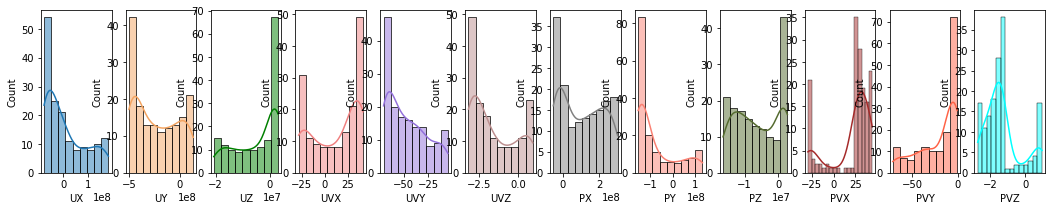

In [35]:
#g = df.plot.hist(subplots=True, layout = (3,3), figsize=(10,10))

#g = sns.displot(df['UX'], kde = True)   #does not use

#g = sns.lineplot(data=df)

#g= sns.ecdfplot(data=df)

#g= sns.pairplot(df)

#g= sns.rugplot(data=df)

fig1, axes = plt.subplots(1,12, figsize=(18,3))
#sns.barplot(data=df['UX'], ax=axes[0] )
sns.histplot(data=df['UX'], ax = axes[0], kde = True)
sns.histplot(data=df['UY'], ax = axes[1], kde = True, color = 'sandybrown')
sns.histplot(data=df['UZ'], ax = axes[2], kde = True, color = 'g')
sns.histplot(data=df['UVX'], ax = axes[3], kde = True, color = 'lightcoral')
sns.histplot(data=df['UVY'], ax = axes[4], kde = True, color = 'mediumpurple')
sns.histplot(data=df['UVZ'], ax = axes[5], kde = True, color = 'rosybrown')
sns.histplot(data=df['PX'], ax = axes[6], kde = True, color= 'gray')
sns.histplot(data=df['PY'], ax = axes[7], kde = True, color = 'salmon')
sns.histplot(data=df['PZ'], ax = axes[8], kde = True, color = 'darkolivegreen')
sns.histplot(data=df['PVX'], ax = axes[9], kde = True, color = 'brown')
sns.histplot(data=df['PVY'], ax = axes[10], kde = True, color = 'tomato')
sns.histplot(data=df['PVZ'], ax = axes[11], kde = True, color = 'aqua')


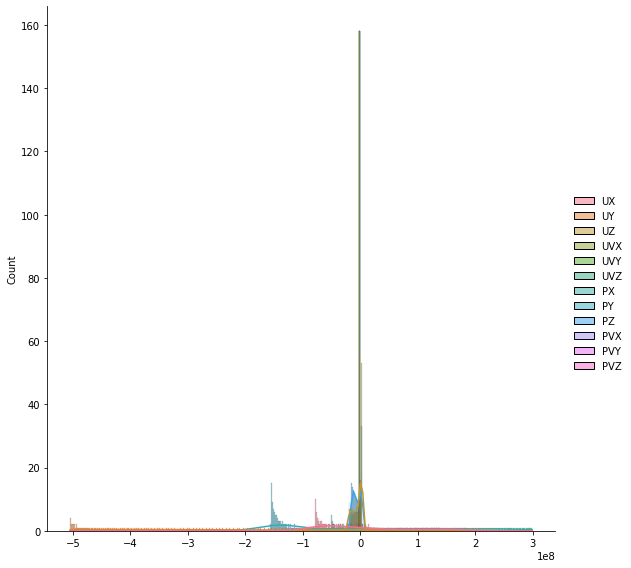

In [36]:
sns.displot(df, kde=True, height= 8 )

Note that the perturbed velocities (PVX, PVY, PVZ) are heavily skewed. Thus, may have a domineering behavior in the learning process (heavier weights).

Text(0.5, 0, 'z')

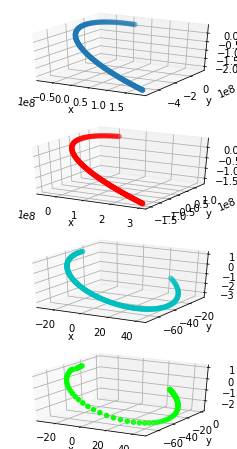

In [37]:
fig2 = plt.figure(figsize= plt.figaspect(2,))
ax2 = fig2.add_subplot(4,1,1, projection = '3d')
ax2.scatter3D(df['UX'], df['UY'], df['UZ'])
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

ax3 = fig2.add_subplot(4,1,2, projection = '3d')
ax3.scatter3D(df['PX'], df['PY'], df['PZ'], color = 'r')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')

ax4 = fig2.add_subplot(4,1,3, projection = '3d')
ax4.scatter3D(df['UVX'], df['UVY'], df['UVZ'], color = 'c')
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('z')

ax5 = fig2.add_subplot(4,1,4, projection = '3d')
ax5.scatter3D(df['PVX'], df['PVY'], df['PVZ'], color = 'lime')
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_zlabel('z')


In [38]:
fig3 = px.scatter_3d(df, x = 'UX', y='UY', z = 'UZ')
fig4 = px.scatter_3d(df, x= 'PX', y= 'PY', z='PZ')

fig5 = px.scatter_3d(df, x= 'UVX', y='UVY', z='UVZ')
fig6= px.scatter_3d(df, x='PVX', y='PVY', z='PVZ')

fig3.show()
fig4.show()
fig5.show()
fig6.show()

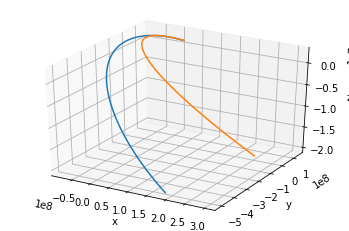

In [39]:
fig7= plt.figure()
ax6 = fig7.gca(projection = '3d') 
ax6.plot(df['UX'], df['UY'], df['UZ'])
ax6.plot(df['PX'], df['PY'], df['PZ'])

ax6.set_xlabel('x')
ax6.set_ylabel('y')
ax6.set_zlabel('z')

plt.show()


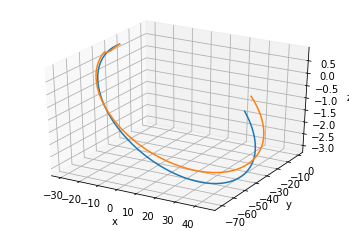

In [40]:
fig8= plt.figure()
ax7 = fig8.gca(projection = '3d') 
ax7.plot(df['UVX'], df['UVY'], df['UVZ'])
ax7.plot(df['PVX'], df['PVY'], df['PVZ'])

ax7.set_xlabel('x')
ax7.set_ylabel('y')
ax7.set_zlabel('z')

plt.show()

# Splitting and Reshaping/Transforming Data <br>
<p> Must split the data between training (input[X]) and testing(output/label [Y]) <p>

In [41]:
dataset= df.values
print(dataset)

[[ 1.38413903e+07  1.35428865e+08  1.28201482e+06 ... -2.76230802e+01
  -2.91753538e+01  9.41112714e-01]
 [ 1.14472029e+07  1.32866126e+08  1.36318650e+06 ... -2.76822924e+01
  -2.98040016e+01  9.34911821e-01]
 [ 9.03948556e+06  1.30219131e+08  1.44398239e+06 ... -2.77333799e+01
  -3.04602314e+01  9.27909029e-01]
 ...
 [ 1.78840618e+08 -5.03785703e+08 -2.04040578e+07 ...  2.46099896e+01
  -8.59036299e-01 -1.17369323e+00]
 [ 1.80991733e+08 -5.04279957e+08 -2.05568470e+07 ...  2.45193083e+01
  -8.11522102e-01 -1.16871500e+00]
 [ 1.83070962e+08 -5.04731933e+08 -2.07049078e+07 ...  2.44295273e+01
  -7.64792931e-01 -1.16379079e+00]]


In [42]:
dataset.shape

(158, 12)

In [43]:
X1 = dataset[:, 0:6]   # Out of the matrix called dataset you are capturing all the rows (is the first element -colon only). 
#[from n row : to m row, from n column : to m column]
X1

array([[ 1.38413903e+07,  1.35428865e+08,  1.28201482e+06,
        -2.76230802e+01, -2.91753538e+01,  9.41112714e-01],
       [ 1.14472029e+07,  1.32866126e+08,  1.36318650e+06,
        -2.77933695e+01, -3.01481368e+01,  9.37586723e-01],
       [ 9.03948556e+06,  1.30219131e+08,  1.44398239e+06,
        -2.79362463e+01, -3.11256174e+01,  9.32414257e-01],
       [ 6.62061303e+06,  1.27487507e+08,  1.52426034e+06,
        -2.80515708e+01, -3.21070187e+01,  9.25597885e-01],
       [ 4.19297104e+06,  1.24670948e+08,  1.60387847e+06,
        -2.81392253e+01, -3.30915620e+01,  9.17141435e-01],
       [ 1.75895460e+06,  1.21769217e+08,  1.68269529e+06,
        -2.81991131e+01, -3.40784703e+01,  9.07049886e-01],
       [-6.79033787e+05,  1.18782142e+08,  1.76056977e+06,
        -2.82311568e+01, -3.50669769e+01,  8.95329064e-01],
       [-3.11858551e+06,  1.15709618e+08,  1.83736139e+06,
        -2.82352907e+01, -3.60563511e+01,  8.81984620e-01],
       [-5.55728574e+06,  1.12551597e+08,  1.912

In [44]:
X1.shape

(158, 6)

In [45]:
Y1 = dataset[:, 6:13]
Y1

array([[ 1.38413903e+07,  1.35428865e+08,  1.28201482e+06,
        -2.76230802e+01, -2.91753538e+01,  9.41112714e-01],
       [ 1.14521438e+07,  1.32881149e+08,  1.36306456e+06,
        -2.76822924e+01, -2.98040016e+01,  9.34911821e-01],
       [ 9.05812401e+06,  1.30277939e+08,  1.44354450e+06,
        -2.77333799e+01, -3.04602314e+01,  9.27909029e-01],
       [ 6.66008522e+06,  1.27616772e+08,  1.52338161e+06,
        -2.77751039e+01, -3.11459262e+01,  9.20015774e-01],
       [ 4.25889660e+06,  1.24895016e+08,  1.60249471e+06,
        -2.78060374e+01, -3.18631351e+01,  9.11131758e-01],
       [ 1.85555994e+06,  1.22109851e+08,  1.68079338e+06,
        -2.78245320e+01, -3.26140903e+01,  9.01143045e-01],
       [-5.48769599e+05,  1.19258259e+08,  1.75817669e+06,
        -2.78286783e+01, -3.34012306e+01,  8.89919714e-01],
       [-2.95275885e+06,  1.16336999e+08,  1.83453168e+06,
        -2.78162557e+01, -3.42272366e+01,  8.77312693e-01],
       [-5.35486692e+06,  1.13342587e+08,  1.909

In [46]:
Y1.shape

(158, 6)

In [47]:
dataset2= df2.values
print(dataset2)

[[-1.64982618e+07  1.32113688e+08  2.99648197e+06 ... -2.41435334e+01
  -3.23758480e+01  6.86116238e-01]
 [-1.85810293e+07  1.29273780e+08  3.05499055e+06 ... -2.40558356e+01
  -3.30288455e+01  6.70995132e-01]
 [-2.06557249e+07  1.26348730e+08  3.11186458e+06 ... -2.39518895e+01
  -3.37057549e+01  6.54663238e-01]
 ...
 [ 2.41101932e+08 -4.08127204e+08 -2.28356562e+07 ...  2.49882194e+01
  -1.73318679e+00 -1.23016492e+00]
 [ 2.42918668e+08 -4.07825244e+08 -2.29592716e+07 ...  2.48973614e+01
  -1.67337946e+00 -1.22476924e+00]
 [ 2.44655213e+08 -4.07499999e+08 -2.30779401e+07 ...  2.48073558e+01
  -1.61455265e+00 -1.21943142e+00]]


In [48]:
dataset2.shape

(158, 12)

In [49]:
X2 = dataset2[:, 0:6]
X2

array([[-1.64982618e+07,  1.32113688e+08,  2.99648197e+06,
        -2.41435334e+01, -3.23758480e+01,  6.86116238e-01],
       [-1.85810293e+07,  1.29273780e+08,  3.05499055e+06,
        -2.40640334e+01, -3.33624309e+01,  6.67985684e-01],
       [-2.06557249e+07,  1.26348730e+08,  3.11186458e+06,
        -2.39566920e+01, -3.43465790e+01,  6.48281750e-01],
       [-2.27199458e+07,  1.23338784e+08,  3.16696874e+06,
        -2.38215756e+01, -3.53274998e+01,  6.27019090e-01],
       [-2.47712958e+07,  1.20244254e+08,  3.22016904e+06,
        -2.36587723e+01, -3.63044063e+01,  6.04213518e-01],
       [-2.68073873e+07,  1.17065520e+08,  3.27133289e+06,
        -2.34683907e+01, -3.72765209e+01,  5.79881804e-01],
       [-2.88258430e+07,  1.13803031e+08,  3.32032916e+06,
        -2.32505552e+01, -3.82430864e+01,  5.54041169e-01],
       [-3.08242963e+07,  1.10457295e+08,  3.36702821e+06,
        -2.30053915e+01, -3.92033986e+01,  5.26707587e-01],
       [-3.28003895e+07,  1.07028879e+08,  3.411

In [50]:
X2.shape

(158, 6)

In [51]:
Y2 = dataset2[:, 6:13]
Y2

array([[-1.64982618e+07,  1.32113688e+08,  2.99648197e+06,
        -2.41435334e+01, -3.23758480e+01,  6.86116238e-01],
       [-1.85805856e+07,  1.29288373e+08,  3.05511753e+06,
        -2.40558356e+01, -3.30288455e+01,  6.70995132e-01],
       [-2.06546424e+07,  1.26405615e+08,  3.11239507e+06,
        -2.39518895e+01, -3.37057549e+01,  6.54663238e-01],
       [-2.27189540e+07,  1.23463296e+08,  3.16820538e+06,
        -2.38299438e+01, -3.44077675e+01,  6.37012731e-01],
       [-2.47718820e+07,  1.20459194e+08,  3.22242947e+06,
        -2.36880371e+01, -3.51361258e+01,  6.17924333e-01],
       [-2.68116088e+07,  1.17390977e+08,  3.27493750e+06,
        -2.35239694e+01, -3.58921225e+01,  5.97265855e-01],
       [-2.88361148e+07,  1.14256201e+08,  3.32558757e+06,
        -2.33352677e+01, -3.66771015e+01,  5.74890376e-01],
       [-3.08431536e+07,  1.11052299e+08,  3.37422439e+06,
        -2.31191417e+01, -3.74924712e+01,  5.50633557e-01],
       [-3.28302215e+07,  1.07776582e+08,  3.420

In [52]:
Y2.shape

(158, 6)

In [53]:
dataset3= df3.values
print(dataset3)

[[-4.79211902e+07  1.20244161e+08  4.66387223e+06 ... -1.96740793e+01
  -3.54567017e+01  3.66833722e-01]
 [-4.96060122e+07  1.17140601e+08  4.69414950e+06 ... -1.94099249e+01
  -3.60994814e+01  3.41490238e-01]
 [-5.12592884e+07  1.13957419e+08  4.72151331e+06 ... -1.91220379e+01
  -3.67589270e+01  3.14619420e-01]
 ...
 [ 2.78208425e+08 -2.94986840e+08 -2.39149627e+07 ...  2.51359031e+01
  -2.54685894e+00 -1.28383536e+00]
 [ 2.79421567e+08 -2.93979012e+08 -2.39974464e+07 ...  2.50472448e+01
  -2.47512765e+00 -1.27804756e+00]
 [ 2.80550997e+08 -2.92970737e+08 -2.40750935e+07 ...  2.49593321e+01
  -2.40454416e+00 -1.27231936e+00]]


In [54]:
dataset3.shape

(158, 12)

In [55]:
X3=dataset3[:,0:6]
X3

array([[-4.79211902e+07,  1.20244161e+08,  4.66387223e+06,
        -1.96740793e+01, -3.54567017e+01,  3.66833722e-01],
       [-4.96060122e+07,  1.17140601e+08,  4.69414950e+06,
        -1.93220511e+01, -3.63833161e+01,  3.33798898e-01],
       [-5.12592884e+07,  1.13957419e+08,  4.72151331e+06,
        -1.89439012e+01, -3.72996882e+01,  2.99397084e-01],
       [-5.28787744e+07,  1.10695531e+08,  4.74584672e+06,
        -1.85399232e+01, -3.82050761e+01,  2.63655325e-01],
       [-5.44622522e+07,  1.07355919e+08,  4.76703517e+06,
        -1.81104300e+01, -3.90987513e+01,  2.26601527e-01],
       [-5.60075314e+07,  1.03939625e+08,  4.78496650e+06,
        -1.76557504e+01, -3.99800044e+01,  1.88264106e-01],
       [-5.75124502e+07,  1.00447752e+08,  4.79953104e+06,
        -1.71762205e+01, -4.08481589e+01,  1.48671097e-01],
       [-5.89748758e+07,  9.68814577e+07,  4.81062143e+06,
        -1.66721567e+01, -4.17026162e+01,  1.07847183e-01],
       [-6.03926977e+07,  9.32419441e+07,  4.818

In [56]:
X3.shape

(158, 6)

In [57]:
Y3=dataset[:,6:13]
Y3

array([[ 1.38413903e+07,  1.35428865e+08,  1.28201482e+06,
        -2.76230802e+01, -2.91753538e+01,  9.41112714e-01],
       [ 1.14521438e+07,  1.32881149e+08,  1.36306456e+06,
        -2.76822924e+01, -2.98040016e+01,  9.34911821e-01],
       [ 9.05812401e+06,  1.30277939e+08,  1.44354450e+06,
        -2.77333799e+01, -3.04602314e+01,  9.27909029e-01],
       [ 6.66008522e+06,  1.27616772e+08,  1.52338161e+06,
        -2.77751039e+01, -3.11459262e+01,  9.20015774e-01],
       [ 4.25889660e+06,  1.24895016e+08,  1.60249471e+06,
        -2.78060374e+01, -3.18631351e+01,  9.11131758e-01],
       [ 1.85555994e+06,  1.22109851e+08,  1.68079338e+06,
        -2.78245320e+01, -3.26140903e+01,  9.01143045e-01],
       [-5.48769599e+05,  1.19258259e+08,  1.75817669e+06,
        -2.78286783e+01, -3.34012306e+01,  8.89919714e-01],
       [-2.95275885e+06,  1.16336999e+08,  1.83453168e+06,
        -2.78162557e+01, -3.42272366e+01,  8.77312693e-01],
       [-5.35486692e+06,  1.13342587e+08,  1.909

In [58]:
Y3.shape

(158, 6)

# Scaling and Normalizing Data

(x - mean)/ sigma; is the standardization equation; or is considered as<br/>
StandardScaler provided by sklearn tools. It is normalization via the Z-score (also called standard normalization in statistical journals), and it's done per feature. Which may or maynot be used for this type of analysis. This section will test this out.
The range by default is between -3 and 3, but can still be used if the data is already scaled within a unit variance and has a mean of 0 (where its attributes with_mean and with_std = False) .

 (x - mean)/(max - min) is the mean normalization equation. and will be used over the whole dataset instead of just a feature. The default range, for this type of normalization, is -1 and 1 with a mean of 0.


##Let's First do mean normalization with respect to a feature

In [59]:
#sum of all the values in the dataset - since it is an array and no longer a Panda dataframe
UX_total = X1[:, 0].sum()      #equivelant to numpy.sum
UX_total

963999935.3196001

In [60]:
UY_total = X1[:,1].sum()      #equivelant to numpy.sum
UY_total

-36201737670.486

In [61]:
UZ_total = X1[:,2].sum()      #equivelant to numpy.sum
UZ_total

-788801440.696796

In [62]:
df_sumpf= df.sum()   #gives me a Panda Series object of the sum of each index or column or feature of the Panda dataframe labeled 'df'; it is important to note 
                      #that in standard python indexing is referred to column selections and splicing is referred to row selections; however, in Pandas, indexing can
                      #be referred to selecting either columns or rows or some of the columns and all of the rows, or all of the columns and some of the rows. Also, using
                      # .index at the end of a dataframe name (such as df, df2, and df3), will give the sum of the rows.
df_sumpf    # sum per feature (sumpf) of df (dataset1) - as verification using Panda Dataframe lingo

UX     9.639999e+08
UY    -3.620174e+10
UZ    -7.888014e+08
UVX    1.956635e+03
UVY   -7.426230e+03
UVZ   -2.548462e+02
PX     1.650393e+10
PY    -1.273330e+10
PZ    -9.664594e+08
PVX    3.300004e+03
PVY   -3.379007e+03
PVZ   -2.047414e+02
dtype: float64

In [63]:
#Testing:
#sum_df_sumpf = df_sumpf.sum()
#sum_df_sumpf

In [64]:
#testing
#dataset.size

In [65]:
mean_UX = UX_total/X1[:,0].size
mean_UX

6101265.413415191

In [66]:
mean_UY = UY_total/X1[:,1].size
mean_UY

-229124921.96510127

In [67]:
mean_UZ = UZ_total/X1[:,2].size
mean_UZ

-4992414.181625291

In [68]:
UX = X1[:,0]
UXmax, UXmin = UX.max(), UX.min()
UXmN = (UX - mean_UX)/(UXmax - UXmin)
print("After mean Normalizing UX:")
print(UXmN)

After mean Normalizing UX:
[ 0.0295853   0.02043393  0.01123084  0.00198512 -0.00729413 -0.01659774
 -0.02591653 -0.0352413  -0.04456282 -0.05387177 -0.06315444 -0.07239899
 -0.08160352 -0.09075889 -0.09985596 -0.10888565 -0.11783893 -0.12670682
 -0.13548041 -0.14415086 -0.15270942 -0.16114741 -0.16945627 -0.1776275
 -0.18565276 -0.1935238  -0.20123248 -0.20877081 -0.21613094 -0.22330515
 -0.23028587 -0.23706571 -0.24363741 -0.2499939  -0.25612829 -0.26203385
 -0.26770405 -0.27313255 -0.2783132  -0.28324008 -0.28790745 -0.29230978
 -0.29644177 -0.30029835 -0.30387465 -0.30716606 -0.31016817 -0.31287683
 -0.31528813 -0.31739838 -0.31920416 -0.3207023  -0.32188986 -0.32276416
 -0.32332279 -0.32356359 -0.32348464 -0.32308431 -0.3223612  -0.32131419
 -0.31994243 -0.3182453  -0.31622247 -0.31387387 -0.31119968 -0.30820035
 -0.30487658 -0.30122934 -0.29725985 -0.2929696  -0.28836031 -0.28343399
 -0.27819286 -0.27263941 -0.26677638 -0.26060674 -0.2541337  -0.24736073
 -0.24029151 -0.23292996 

In [69]:
UXmN.shape

(158,)

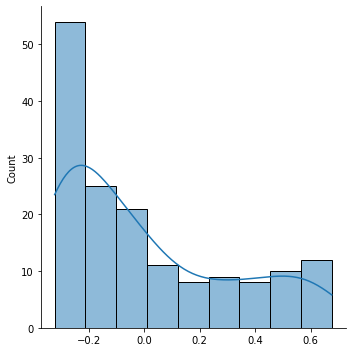

In [70]:
sns.displot(UXmN, kde = True)

In [71]:
#Testing to see that the range was btwn (-1, 1):
print(UXmN.min())
print(UXmN.max())

-0.3235635894981654
0.6764364105018346


In [72]:

UY = X1[:,1]
UYmax, UYmin = UY.max(), UY.min()
UYmN = (UY - mean_UY)/(UYmax - UYmin)
print("After mean Normalizing UY:")
print(UYmN)

After mean Normalizing UY:
[ 0.56947221  0.56546894  0.56133405  0.55706696  0.55266719  0.54813437
  0.54346824  0.53866863  0.53373546  0.52866869  0.52346793  0.51813569
  0.51267115  0.50707456  0.50134649  0.49548763  0.48949878  0.48338086
  0.47713488  0.47076197  0.46426336  0.45764038  0.45089448  0.44402717
  0.4370401   0.429935    0.4227137   0.41537811  0.40793027  0.40037227
  0.39270631  0.38493469  0.37705978  0.36908402  0.36100997  0.35284024
  0.34457753  0.33622461  0.32778432  0.31925959  0.3106534   0.30196879
  0.29320889  0.28437685  0.27547593  0.26650939  0.25748059  0.2483929
  0.23924976  0.23005465  0.22081109  0.21152262  0.20219284  0.19282537
  0.18342386  0.17399198  0.16453343  0.15505193  0.1455512   0.13603498
  0.12650704  0.11697113  0.10743102  0.09789046  0.08835323  0.07882307
  0.06930373  0.05979894  0.05031242  0.04084788  0.03140899  0.0219994
  0.01262276  0.00328264 -0.00601737 -0.01527376 -0.02448303 -0.03364172
 -0.04274644 -0.05179381 -

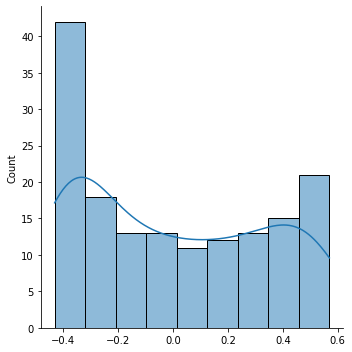

In [73]:
sns.displot(UYmN, kde=True)

In [74]:
#Testing to see that the range was btwn (-1, 1):
print(UYmN.min())
print(UYmN.max())

-0.4305277865387908
0.5694722134612094


UGH....gotta keep going like this for every feature....but what if...

##Now, let's try a faster approach to mean normalizing each feature for inputs and outputs.

Testing some code

In [75]:
#Testing
X1_min = X1.min(axis=0)  #gives me the min value per column/feature
X1_min

array([-7.85496338e+07, -5.04731933e+08, -2.07049078e+07, -2.82352907e+01,
       -7.06915473e+01, -3.20670097e+00])

In [76]:
X1_min.shape

(6,)

In [77]:
X1_max = X1.max(axis = 0)
X1_max

array([ 1.83070962e+08,  1.35428865e+08,  3.02048824e+06,  4.17234814e+01,
       -4.99423974e+00,  9.41112714e-01])

In [78]:
X1_mean = X1.mean(axis=0)
X1_mean

array([ 6.10126541e+06, -2.29124922e+08, -4.99241418e+06,  1.23837679e+01,
       -4.70014541e+01, -1.61295087e+00])

In [79]:
X1[:,0]

array([ 1.38413903e+07,  1.14472029e+07,  9.03948556e+06,  6.62061303e+06,
        4.19297104e+06,  1.75895460e+06, -6.79033787e+05, -3.11858551e+06,
       -5.55728574e+06, -7.99269960e+06, -1.04212373e+07, -1.28398011e+07,
       -1.52478964e+07, -1.76431294e+07, -2.00231111e+07, -2.23854645e+07,
       -2.47278265e+07, -2.70478488e+07, -2.93432005e+07, -3.16115694e+07,
       -3.38506643e+07, -3.60582170e+07, -3.82319839e+07, -4.03697481e+07,
       -4.24693212e+07, -4.45285454e+07, -4.65452948e+07, -4.85174780e+07,
       -5.04430391e+07, -5.23199599e+07, -5.41462617e+07, -5.59200066e+07,
       -5.76392993e+07, -5.93022890e+07, -6.09071705e+07, -6.24521861e+07,
       -6.39356269e+07, -6.53558342e+07, -6.67112011e+07, -6.80001736e+07,
       -6.92212521e+07, -7.03729926e+07, -7.14540076e+07, -7.24629679e+07,
       -7.33986029e+07, -7.42597022e+07, -7.50451164e+07, -7.57537579e+07,
       -7.63846021e+07, -7.69366877e+07, -7.74091179e+07, -7.78010609e+07,
       -7.81117505e+07, -

In [80]:
X1[:,0].shape

(158,)

In [81]:
len(X1[:,0])

158

The loop that is expected to be reused for mean normalizing any dataset.

In [82]:
#i=0
mn_X1 = []
for j in range(len(X1_mean)):
 
  pf_mn_X1 = (X1[:, j] - X1_mean[j])/(X1_max[j] - X1_min[j])
  mn_X1.append(pf_mn_X1)
  mnm_X1 = np.column_stack(np.array(mn_X1))

  j=j+1


print("After mean Normalizing X1:", '\n', mnm_X1)


After mean Normalizing X1: 
 [[ 0.0295853   0.56947221  0.26446045 -0.57186321  0.27133685  0.61576141]
 [ 0.02043393  0.56546894  0.26788175 -0.57429735  0.2565298   0.61491132]
 [ 0.01123084  0.56133405  0.27128721 -0.57633965  0.24165125  0.61366429]
 [ 0.00198512  0.55706696  0.27467084 -0.57798811  0.22671303  0.61202092]
 [-0.00729413  0.55266719  0.27802666 -0.57924106  0.21172697  0.60998215]
 [-0.01659774  0.54813437  0.28134871 -0.5800971   0.19670492  0.60754917]
 [-0.02591653  0.54346824  0.28463103 -0.58055514  0.18165854  0.60472339]
 [-0.0352413   0.53866863  0.28786772 -0.58061423  0.16659896  0.60150616]
 [-0.04456282  0.53373546  0.29105285 -0.58027305  0.15153501  0.59789761]
 [-0.05387177  0.52866869  0.29418047 -0.57952289  0.13645712  0.59388278]
 [-0.06315444  0.52346793  0.29724043 -0.57788577  0.12149262  0.58883134]
 [-0.07239899  0.51813569  0.30022558 -0.5763455   0.10660074  0.58409514]
 [-0.08160352  0.51267115  0.30313629 -0.57441584  0.09168459  0.578975

In [83]:
mnm_X1.shape

(158, 6)

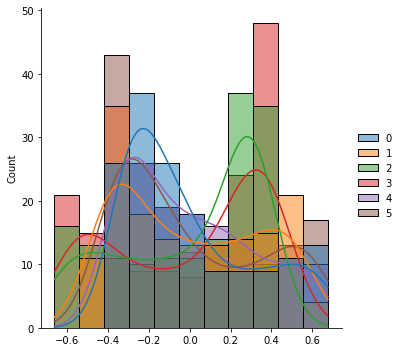

In [84]:
sns.displot(mnm_X1, kde=True)

Note: the plot's distribution for every feature hasn't changed except for the range. This is the same regardless if normalizing the whole input or output separately or every feature. It seems like mean normalization behaves as a  normalizer - where covariance isn't affected; whereas standardization and scaling does. 

In [85]:
Y1_mean = Y1.mean(axis=0)
Y1_mean

array([ 1.04455248e+08, -8.05904974e+07, -6.11683151e+06,  2.08860995e+01,
       -2.13861201e+01, -1.29583165e+00])

In [86]:
Y1_mean.shape

(6,)

In [87]:
#verifying using Panda nomenclature
df.mean()

UX     6.101265e+06
UY    -2.291249e+08
UZ    -4.992414e+06
UVX    1.238377e+01
UVY   -4.700145e+01
UVZ   -1.612951e+00
PX     1.044552e+08
PY    -8.059050e+07
PZ    -6.116832e+06
PVX    2.088610e+01
PVY   -2.138612e+01
PVZ   -1.295832e+00
dtype: float64

In [88]:
Y1_max = Y1.max(axis=0)
Y1_max

array([ 2.99096845e+08,  1.35428865e+08,  2.78541600e+06,  4.44852897e+01,
       -7.64792931e-01,  9.41112714e-01])

In [89]:
Y1_min = Y1.min(axis=0)
Y1_min

array([-5.06309394e+07, -1.55138884e+08, -1.63953117e+07, -2.95977612e+01,
       -7.10302372e+01, -2.67991053e+00])

In [90]:
#i=0

mn_Y1 = []
for j in range(len(Y1_mean)):
 
  pf_mn_Y1 = (Y1[:, j] - Y1_mean[j])/(Y1_max[j] - Y1_min[j])
  mn_Y1.append(pf_mn_Y1)
  mnm_Y1 = np.column_stack(np.array(mn_Y1))

  j=j+1


print("After mean Normalizing Y1:", '\n', mnm_Y1)

After mean Normalizing Y1: 
 [[-2.59098253e-01  7.43438881e-01  3.85743776e-01 -6.54794573e-01
  -1.10854399e-01  6.17765813e-01]
 [-2.65929985e-01  7.34670819e-01  3.89969358e-01 -6.55593841e-01
  -1.19801156e-01  6.16053343e-01]
 [-2.72775366e-01  7.25711774e-01  3.94165233e-01 -6.56283439e-01
  -1.29140452e-01  6.14119417e-01]
 [-2.79632238e-01  7.16553267e-01  3.98327594e-01 -6.56846645e-01
  -1.38899088e-01  6.11939576e-01]
 [-2.86498117e-01  7.07186237e-01  4.02452208e-01 -6.57264196e-01
  -1.49106222e-01  6.09486121e-01]
 [-2.93370138e-01  6.97600987e-01  4.06534361e-01 -6.57513843e-01
  -1.59793626e-01  6.06727588e-01]
 [-3.00244998e-01  6.87787124e-01  4.10568791e-01 -6.57569811e-01
  -1.70996007e-01  6.03628097e-01]
 [-3.07118885e-01  6.77733497e-01  4.14549610e-01 -6.57402127e-01
  -1.82751516e-01  6.00146478e-01]
 [-3.13987393e-01  6.67428113e-01  4.18470203e-01 -6.56975650e-01
  -1.95103062e-01  5.96234752e-01]
 [-3.20845410e-01  6.56857980e-01  4.22323088e-01 -6.56247667e

In [91]:
mnm_Y1.shape

(158, 6)

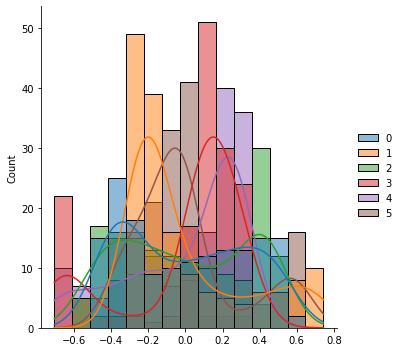

In [92]:
sns.displot(mnm_Y1, kde=True)

In [93]:
X2_mean = X2.mean(axis=0)
X2_mean

array([ 3.56686066e+07, -2.03789843e+08, -6.42248977e+06,  1.91156676e+01,
       -3.96181030e+01, -1.91209395e+00])

In [94]:
X2_min = X2.min(axis=0)
X2_min

array([-7.16870618e+07, -4.09444526e+08, -2.30779401e+07, -2.41435334e+01,
       -6.50186969e+01, -3.37423525e+00])

In [95]:
X2_max = X2.max(axis=0)
X2_max

array([2.44655213e+08, 1.32113688e+08, 3.70631795e+06, 4.57656602e+01,
       3.89059905e+00, 6.86116238e-01])

In [96]:
mn_X2 = []
for j in range(len(X2_mean)):
 
  pf_mn_X2 = (X2[:, j] - X2_mean[j])/(X2_max[j] - X2_min[j])
  mn_X2.append(pf_mn_X2)
  mnm_X2 = np.column_stack(np.array(mn_X2))

  j=j+1
  print("After mean Normalizing X2:", '\n', mnm_X2)

After mean Normalizing X2: 
 [[-0.16490641]
 [-0.17149031]
 [-0.1780487 ]
 [-0.18457398]
 [-0.19105857]
 [-0.19749493]
 [-0.20387553]
 [-0.21019291]
 [-0.2164396 ]
 [-0.2226081 ]
 [-0.22868379]
 [-0.23465753]
 [-0.24053173]
 [-0.24629919]
 [-0.25195286]
 [-0.25748583]
 [-0.26289125]
 [-0.26816242]
 [-0.27329271]
 [-0.27827563]
 [-0.2831048 ]
 [-0.28777395]
 [-0.29227697]
 [-0.29660785]
 [-0.30076076]
 [-0.30472998]
 [-0.30850996]
 [-0.31209529]
 [-0.31548074]
 [-0.31866122]
 [-0.32163181]
 [-0.32438779]
 [-0.32692457]
 [-0.32923779]
 [-0.33132323]
 [-0.33317688]
 [-0.33479492]
 [-0.3361737 ]
 [-0.3373098 ]
 [-0.33819997]
 [-0.33884117]
 [-0.33923057]
 [-0.33936555]
 [-0.33924366]
 [-0.33886272]
 [-0.3382207 ]
 [-0.33731584]
 [-0.33614653]
 [-0.33471144]
 [-0.3330094 ]
 [-0.3310395 ]
 [-0.32880102]
 [-0.32629345]
 [-0.32351653]
 [-0.32047018]
 [-0.31715457]
 [-0.31357006]
 [-0.30971723]
 [-0.30559689]
 [-0.30121004]
 [-0.29655792]
 [-0.29164195]
 [-0.28646378]
 [-0.28102527]
 [-0.275328

In [97]:
mnm_X2.shape

(158, 6)

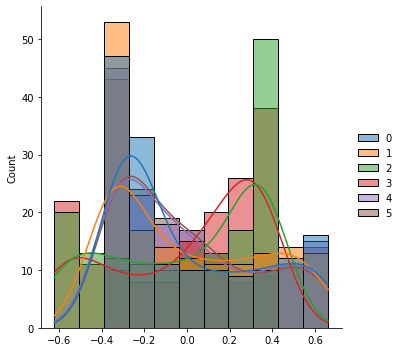

In [98]:
sns.displot(mnm_X2, kde=True)

In [99]:
Y2_mean = Y2.mean(axis=0)
Y2_mean

array([ 8.03315023e+07, -9.28600333e+07, -5.46265008e+06,  2.12771518e+01,
       -2.28613003e+01, -1.41070365e+00])

In [100]:
Y2_min = Y2.min(axis=0)
Y2_min

array([-6.41305558e+07, -1.78403178e+08, -1.62342022e+07, -2.42012382e+01,
       -6.27714303e+01, -2.52467556e+00])

In [101]:
Y2_max = Y2.max(axis=0)
Y2_max

array([ 2.73922868e+08,  1.32113688e+08,  3.72660512e+06,  3.98986309e+01,
       -1.61455265e+00,  6.86116238e-01])

In [102]:
mn_Y2 = []
for j in range(len(Y2_mean)):
 
  pf_mn_Y2 = (Y2[:, j] - Y2_mean[j])/(Y2_max[j] - Y2_min[j])
  mn_Y2.append(pf_mn_Y2)
  mnm_Y2 = np.column_stack(np.array(mn_Y2))

  j=j+1
  print("After mean Normalizing Y2:", '\n', mnm_Y2)

After mean Normalizing Y2: 
 [[-0.28643332]
 [-0.29259307]
 [-0.29872836]
 [-0.30483482]
 [-0.31090762]
 [-0.31694136]
 [-0.32293007]
 [-0.32886712]
 [-0.33474509]
 [-0.34055569]
 [-0.34628886]
 [-0.35251909]
 [-0.35865315]
 [-0.36467538]
 [-0.37057088]
 [-0.3763231 ]
 [-0.38191362]
 [-0.38732195]
 [-0.39252538]
 [-0.39749876]
 [-0.40221441]
 [-0.40664194]
 [-0.41074823]
 [-0.41449749]
 [-0.41785136]
 [-0.42076931]
 [-0.4232091 ]
 [-0.42512762]
 [-0.42648192]
 [-0.42723051]
 [-0.42733499]
 [-0.42676178]
 [-0.42548391]
 [-0.42348275]
 [-0.42074939]
 [-0.41728551]
 [-0.4131037 ]
 [-0.40822702]
 [-0.40268795]
 [-0.39652681]
 [-0.38978986]
 [-0.38252719]
 [-0.37479086]
 [-0.36663302]
 [-0.35810457]
 [-0.34925397]
 [-0.34012658]
 [-0.33076409]
 [-0.32120441]
 [-0.31148157]
 [-0.30162591]
 [-0.29166421]
 [-0.28162001]
 [-0.2715139 ]
 [-0.26136375]
 [-0.2511851 ]
 [-0.24099134]
 [-0.23079401]
 [-0.22060302]
 [-0.21042687]
 [-0.2002728 ]
 [-0.19014699]
 [-0.18005468]
 [-0.17000027]
 [-0.159987

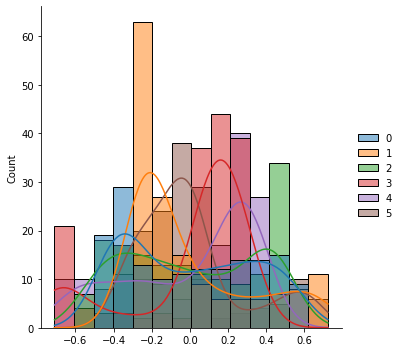

In [103]:
sns.displot(mnm_Y2, kde=True)

In [104]:
X3_mean = X3.mean(axis=0)
X3_mean

array([ 5.91095489e+07, -1.71567862e+08, -7.56548897e+06,  2.40387120e+01,
       -3.03441589e+01, -2.10679530e+00])

In [105]:
X3_min = X3.min(axis=0)
X3_min

array([-7.63407338e+07, -3.13988041e+08, -2.40750935e+07, -1.96740793e+01,
       -5.83647774e+01, -3.46856386e+00])

In [106]:
X3_max = X3.max(axis=0)
X3_max

array([2.80550997e+08, 1.20244161e+08, 4.82195245e+06, 4.83039485e+01,
       1.16717474e+01, 3.66833722e-01])

In [107]:
#getting inf values...
#np.seterr(divide='ignore', invalid='ignore')

mn_X3 = []
for j in range(len(X3_mean)):
 
  pf_mn_X3 = (X3[:, j] - X3_mean[j])/(X3_max[j] - X3_min[j])
  mn_X3.append(pf_mn_X3)
  mnm_X3 = np.column_stack(np.array(mn_X3))

  j=j+1
  print("After mean Normalizing X3:", '\n', mnm_X3)

After mean Normalizing X3: 
 [[-0.29989694]
 [-0.30461776]
 [-0.3092502 ]
 [-0.31378795]
 [-0.3182248 ]
 [-0.32255463]
 [-0.32677137]
 [-0.33086904]
 [-0.33484174]
 [-0.33868346]
 [-0.3423697 ]
 [-0.34589315]
 [-0.34926974]
 [-0.35249388]
 [-0.35556031]
 [-0.35846396]
 [-0.36119988]
 [-0.36376329]
 [-0.36614953]
 [-0.3683541 ]
 [-0.37037265]
 [-0.37220096]
 [-0.37383499]
 [-0.37527086]
 [-0.37650483]
 [-0.37753335]
 [-0.37835303]
 [-0.37896064]
 [-0.37935314]
 [-0.37952766]
 [-0.3794815 ]
 [-0.37921214]
 [-0.37871727]
 [-0.37799473]
 [-0.37704256]
 [-0.37585898]
 [-0.37444241]
 [-0.37279146]
 [-0.37090491]
 [-0.36878176]
 [-0.36642117]
 [-0.36382251]
 [-0.36098535]
 [-0.35790943]
 [-0.3545947 ]
 [-0.3510413 ]
 [-0.34724956]
 [-0.34321998]
 [-0.33895328]
 [-0.33445036]
 [-0.32971231]
 [-0.32474038]
 [-0.31953605]
 [-0.31410095]
 [-0.3084369 ]
 [-0.30254592]
 [-0.29643017]
 [-0.29009202]
 [-0.283534  ]
 [-0.27675881]
 [-0.26976933]
 [-0.26256859]
 [-0.2551598 ]
 [-0.24754631]
 [-0.239731

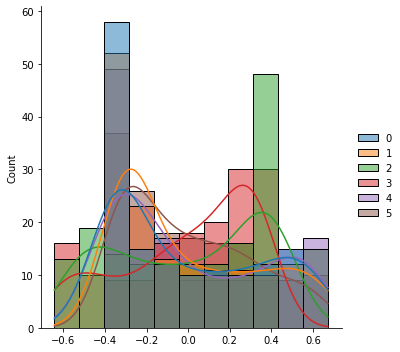

In [108]:
sns.displot(mnm_X3, kde=True)

In [109]:
Y3_mean = Y3.mean(axis=0)
Y3_mean

array([ 1.04455248e+08, -8.05904974e+07, -6.11683151e+06,  2.08860995e+01,
       -2.13861201e+01, -1.29583165e+00])

In [110]:
Y3_min = Y3.min(axis=0)
Y3_min

array([-5.06309394e+07, -1.55138884e+08, -1.63953117e+07, -2.95977612e+01,
       -7.10302372e+01, -2.67991053e+00])

In [111]:
Y3_max = Y3.max(axis=0)
Y3_max

array([ 2.99096845e+08,  1.35428865e+08,  2.78541600e+06,  4.44852897e+01,
       -7.64792931e-01,  9.41112714e-01])

In [112]:

mn_Y3 = []
for j in range(len(Y3_mean)):
 
  pf_mn_Y3 = (Y3[:, j] - Y3_mean[j])/(Y3_max[j] - Y3_min[j])
  mn_Y3.append(pf_mn_Y3)
  mnm_Y3 = np.column_stack(np.array(mn_Y3))

  j=j+1
  print("After mean Normalizing Y3:", '\n', mnm_Y3)

After mean Normalizing Y3: 
 [[-0.25909825]
 [-0.26592998]
 [-0.27277537]
 [-0.27963224]
 [-0.28649812]
 [-0.29337014]
 [-0.300245  ]
 [-0.30711888]
 [-0.31398739]
 [-0.32084541]
 [-0.327687  ]
 [-0.33501205]
 [-0.34230692]
 [-0.34956056]
 [-0.35676159]
 [-0.36389676]
 [-0.37095059]
 [-0.377905  ]
 [-0.38473882]
 [-0.39142724]
 [-0.39794125]
 [-0.40424687]
 [-0.41030439]
 [-0.41606757]
 [-0.4214828 ]
 [-0.42648832]
 [-0.43101381]
 [-0.43498028]
 [-0.43830083]
 [-0.44088244]
 [-0.44262939]
 [-0.44344829]
 [-0.44325494]
 [-0.44198226]
 [-0.43958823]
 [-0.43606209]
 [-0.43142726]
 [-0.42573997]
 [-0.41908385]
 [-0.41156174]
 [-0.40328654]
 [-0.39437293]
 [-0.3849308 ]
 [-0.37506095]
 [-0.36485286]
 [-0.3543839 ]
 [-0.34371973]
 [-0.33291523]
 [-0.32201576]
 [-0.31105849]
 [-0.30007364]
 [-0.28908566]
 [-0.27811419]
 [-0.26717497]
 [-0.25628048]
 [-0.24544059]
 [-0.234663  ]
 [-0.22395371]
 [-0.21331726]
 [-0.20275705]
 [-0.19227554]
 [-0.18187444]
 [-0.17155482]
 [-0.16131728]
 [-0.151162

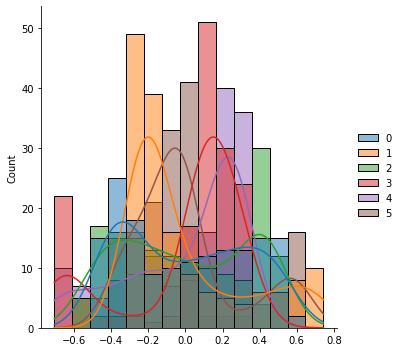

In [113]:
sns.displot(mnm_Y3, kde=True)

## Then let's test mean normalization over the whole dataset.

In [114]:
#sum of all the values in the dataset2 - since it is an array and no longer a Panda dataframe
X1_total = X1.sum()      #equivelant to numpy.sum
X1_total

-36026544900.30386

In [115]:
mean_X1 = X1_total/X1.size
mean_X1

-38002684.49399142

In [116]:
X1max, X1min = X1.max(), X1.min()
X1mN = (X1 - mean_X1)/(X1max - X1min)
print("After mean Normalizing X1:")
print(X1mN)

After mean Normalizing X1:
[[ 7.53763544e-02  2.52152979e-01  5.71162168e-02  5.52522490e-02
   5.52522468e-02  5.52522905e-02]
 [ 7.18954335e-02  2.48427001e-01  5.72342327e-02  5.52522488e-02
   5.52522453e-02  5.52522905e-02]
 [ 6.83948415e-02  2.44578522e-01  5.73517022e-02  5.52522486e-02
   5.52522439e-02  5.52522905e-02]
 [ 6.48780309e-02  2.40607000e-01  5.74684187e-02  5.52522484e-02
   5.52522425e-02  5.52522905e-02]
 [ 6.13484703e-02  2.36511991e-01  5.75841759e-02  5.52522483e-02
   5.52522411e-02  5.52522905e-02]
 [ 5.78096419e-02  2.32293150e-01  5.76987681e-02  5.52522482e-02
   5.52522396e-02  5.52522905e-02]
 [ 5.42650386e-02  2.27950228e-01  5.78119902e-02  5.52522481e-02
   5.52522382e-02  5.52522905e-02]
 [ 5.07181624e-02  2.23483070e-01  5.79236379e-02  5.52522481e-02
   5.52522368e-02  5.52522905e-02]
 [ 4.71725242e-02  2.18891608e-01  5.80335075e-02  5.52522482e-02
   5.52522353e-02  5.52522904e-02]
 [ 4.36316641e-02  2.14175798e-01  5.81413929e-02  5.52522482e-0

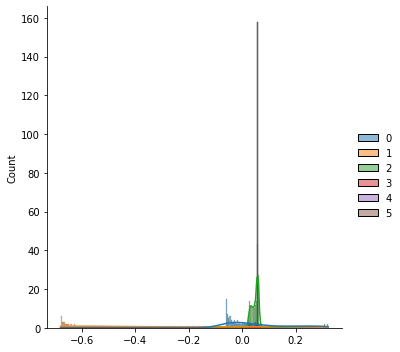

In [117]:
sns.displot(X1mN, kde = True)

In [118]:
#Testing to see that the range was btwn (-1, 1):
print(X1mN.min())
print(X1mN.max())

-0.6785799416606768
0.3214200583393232


mean norm by feature is different from mean norm for the full dataset. Looking into statistics, doing the mean per group, sample, population or feature is common practice. But normalizing a whole dataset, cross-variables, is not.

## Let's try scaling every feature . 

In [119]:
scaler_X1= preprocessing.scale(X1, with_mean= True, with_std = True)  #meaning turning central tendency and std_deviation ON. Cuz want normal distribution.
 # it doesn't have fit or transform attributes. 
scaler_X1

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.



array([[ 0.09628975,  1.69083173,  0.78520595, -1.55063414,  0.89262264,
         1.79321379],
       [ 0.06650525,  1.67894553,  0.79536408, -1.55723442,  0.84391158,
         1.79073818],
       [ 0.03655244,  1.66666854,  0.80547519, -1.56277221,  0.7949653 ,
         1.78710658],
       [ 0.00646086,  1.65399903,  0.81552147, -1.5672421 ,  0.7458227 ,
         1.78232079],
       [-0.02373982,  1.64093559,  0.82548519, -1.57063952,  0.69652276,
         1.7763835 ],
       [-0.0540198 ,  1.62747711,  0.83534863, -1.57296072,  0.6471044 ,
         1.7692982 ],
       [-0.08434919,  1.6136228 ,  0.84509414, -1.57420271,  0.597606  ,
         1.76106899],
       [-0.11469803,  1.59937217,  0.85470413, -1.57436294,  0.54806416,
         1.75169982],
       [-0.14503628,  1.584725  ,  0.86416107, -1.57343782,  0.49850798,
         1.74119104],
       [-0.17533364,  1.56968115,  0.87344723, -1.57140372,  0.44890591,
         1.72949908],
       [-0.20554547,  1.55423945,  0.88253254, -1.

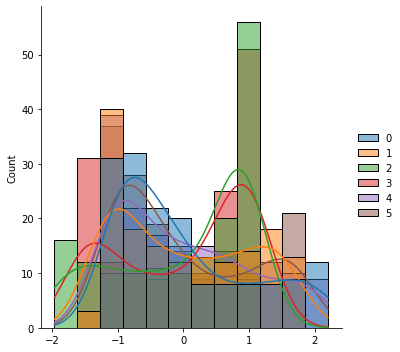

In [120]:
sns.displot(scaler_X1, kde = True)

In [121]:
#scaler_X1= preprocessing.scale(X1, with_mean= True, with_std= True) 
#Sscaled_X1=scaler_X1.fit_transform(X1)  
#scaler_X1
mmscaler= MinMaxScaler(feature_range=(-1,1)) #-1,1 ? b/c 0,1 is slower learning but is ok to use for small sample size
mmscaled_X1=mmscaler.fit_transform(X1)  #didn't need to resize at all
mmscaled_X1

array([[-2.93702213e-01,  1.00000000e+00,  8.53450420e-01,
        -9.82497964e-01,  2.63862861e-01,  1.00000000e+00],
       [-3.12004957e-01,  9.91993455e-01,  8.60293018e-01,
        -9.87366240e-01,  2.34248769e-01,  9.98299832e-01],
       [-3.30411133e-01,  9.83723673e-01,  8.67103938e-01,
        -9.91450839e-01,  2.04491670e-01,  9.95805763e-01],
       [-3.48902586e-01,  9.75189490e-01,  8.73871197e-01,
        -9.94747767e-01,  1.74615216e-01,  9.92519033e-01],
       [-3.67461079e-01,  9.66389955e-01,  8.80582835e-01,
        -9.97253658e-01,  1.44643113e-01,  9.88441487e-01],
       [-3.86068302e-01,  9.57324323e-01,  8.87226923e-01,
        -9.98965747e-01,  1.14599011e-01,  9.83575526e-01],
       [-4.04705890e-01,  9.47992060e-01,  8.93791575e-01,
        -9.99881820e-01,  8.45062515e-02,  9.77923960e-01],
       [-4.23355429e-01,  9.38392834e-01,  9.00264944e-01,
        -1.00000000e+00,  5.43870811e-02,  9.71489513e-01],
       [-4.41998458e-01,  9.28526497e-01,  9.066

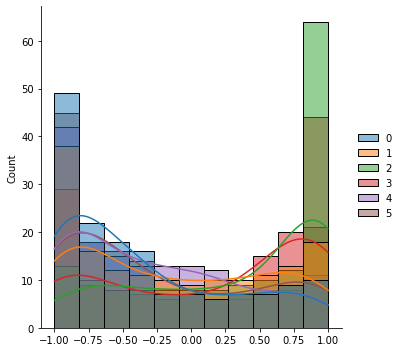

In [122]:
sns.displot(mmscaled_X1, kde = True)

although, min max scalar has a range of (-1, 1), it is not ideal b/c the min and max values will equal to that of the scaled version of the test/validation sets. Thus,when doing seq2seq prediction, this can be misleading b/c the raw values are not equal. 

In [123]:
scaler_stdnorm= StandardScaler()   #with_mean=False, with_std=False are attributes that can be added in StandardScalar; result = unnormalized data
scaler_stdnorm_X1=scaler_stdnorm.fit_transform(X1)  #didn't need to resize at all
scaler_stdnorm_X1

array([[ 0.09628975,  1.69083173,  0.78520595, -1.55063414,  0.89262264,
         1.79321379],
       [ 0.06650525,  1.67894553,  0.79536408, -1.55723442,  0.84391158,
         1.79073818],
       [ 0.03655244,  1.66666854,  0.80547519, -1.56277221,  0.7949653 ,
         1.78710658],
       [ 0.00646086,  1.65399903,  0.81552147, -1.5672421 ,  0.7458227 ,
         1.78232079],
       [-0.02373982,  1.64093559,  0.82548519, -1.57063952,  0.69652276,
         1.7763835 ],
       [-0.0540198 ,  1.62747711,  0.83534863, -1.57296072,  0.6471044 ,
         1.7692982 ],
       [-0.08434919,  1.6136228 ,  0.84509414, -1.57420271,  0.597606  ,
         1.76106899],
       [-0.11469803,  1.59937217,  0.85470413, -1.57436294,  0.54806416,
         1.75169982],
       [-0.14503628,  1.584725  ,  0.86416107, -1.57343782,  0.49850798,
         1.74119104],
       [-0.17533364,  1.56968115,  0.87344723, -1.57140372,  0.44890591,
         1.72949908],
       [-0.20554547,  1.55423945,  0.88253254, -1.

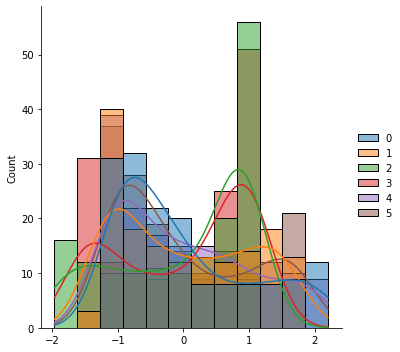

In [124]:
sns.displot(scaler_stdnorm_X1, kde = True)

Get different results when StandardScalar() vs. StandardScalar(with_mean=False, with_std = False). The latter produces the same as the MinMaxScalar. The StandardScalar() gives a range of (-3, 3) by default. But we need a range of (-1, 1).

## Power Transformer Normalization (Box-Cox transform [only positive data values] and the Yeo-Johnson transform [negative and positive data values])

In [125]:
pt= preprocessing.PowerTransformer(method = 'yeo-johnson', standardize= True ) #-1,1 ? b/c 0,1 is slower learning but is ok to use for small sample size
pt_X1=pt.fit_transform(X1)  #didn't need to resize at all
pt_X1

array([[ 4.49214207e-01,  1.96219716e+00,  6.19757682e-01,
        -1.50419178e+00,  9.54603732e-01,  1.65631729e+00],
       [ 4.29134978e-01,  1.94187868e+00,  6.53540685e-01,
        -1.50991280e+00,  9.09657092e-01,  1.65466805e+00],
       [ 4.08825648e-01,  1.92089912e+00,  6.87275128e-01,
        -1.51471202e+00,  8.64076153e-01,  1.65224711e+00],
       [ 3.88271374e-01,  1.89925636e+00,  7.20894222e-01,
        -1.51858519e+00,  8.17900694e-01,  1.64905385e+00],
       [ 3.67430788e-01,  1.87694885e+00,  7.54331378e-01,
        -1.52152872e+00,  7.71171620e-01,  1.64508768e+00],
       [ 3.46180407e-01,  1.85397567e+00,  7.87520231e-01,
        -1.52353966e+00,  7.23930748e-01,  1.64034794e+00],
       [ 3.17701590e-01,  1.83033647e+00,  8.20394658e-01,
        -1.52461557e+00,  6.76220372e-01,  1.63483377e+00],
       [ 2.70444112e-01,  1.80603151e+00,  8.52888787e-01,
        -1.52475437e+00,  6.28081946e-01,  1.62854361e+00],
       [ 2.22043482e-01,  1.78106159e+00,  8.849

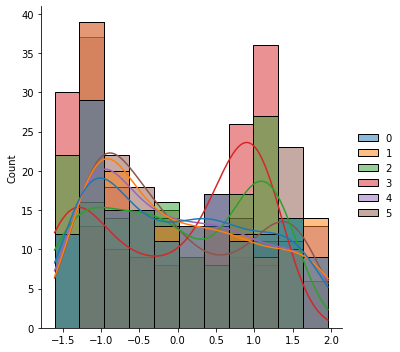

In [126]:
sns.displot(pt_X1, kde = True)

In [127]:
#Testing to see that the range was btwn (-1, 1):
print(pt_X1.min())
print(pt_X1.max())

-1.6062017973015896
1.9621971567322556


##Scaling after Normalization


normalization after scaling (did a powertransform after min max scale - not shown) changes the range from the scaling and readjusts the distributions so that it goes over and/or under that range....maybe it's best to normalize first then scale.  

In [128]:
mmscaler_aft_pt= MinMaxScaler(feature_range=(-1,1)) 
pt_mmscaled_X1=mmscaler_aft_pt.fit_transform(pt_X1)  
pt_mmscaled_X1

array([[ 1.32920498e-01,  1.00000000e+00,  5.00159866e-01,
        -9.84741373e-01,  4.03751382e-01,  1.00000000e+00],
       [ 1.20008887e-01,  9.87189438e-01,  5.22927533e-01,
        -9.88986700e-01,  3.75244407e-01,  9.98843355e-01],
       [ 1.06949314e-01,  9.73962074e-01,  5.45662475e-01,
        -9.92547994e-01,  3.46335134e-01,  9.97145498e-01],
       [ 9.37322343e-02,  9.60316565e-01,  5.68319678e-01,
        -9.95422110e-01,  3.17048793e-01,  9.94906004e-01],
       [ 8.03310457e-02,  9.46251945e-01,  5.90854266e-01,
        -9.97606383e-01,  2.87411326e-01,  9.92124448e-01],
       [ 6.66663456e-02,  9.31767625e-01,  6.13221512e-01,
        -9.99098611e-01,  2.57449256e-01,  9.88800373e-01],
       [ 4.83535214e-02,  9.16863389e-01,  6.35376856e-01,
        -9.99897004e-01,  2.27189408e-01,  9.84933176e-01],
       [ 1.79653951e-02,  9.01539399e-01,  6.57275901e-01,
        -1.00000000e+00,  1.96658074e-01,  9.80521768e-01],
       [-1.31578159e-02,  8.85796157e-01,  6.788

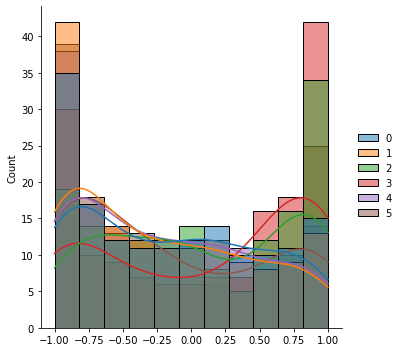

In [129]:
sns.displot(pt_mmscaled_X1, kde= True)

In [130]:
#Testing to see that the range was btwn (-1, 1):
print(pt_mmscaled_X1.min())
print(pt_mmscaled_X1.max())

-1.0
1.0000000000000002


let's try another scaler after normalization

In [131]:
scaler_X1_aft_pt= preprocessing.scale(pt_X1, with_mean= True, with_std = True)
scaler_X1_aft_pt

array([[ 4.49214207e-01,  1.96219716e+00,  6.19757682e-01,
        -1.50419178e+00,  9.54603732e-01,  1.65631729e+00],
       [ 4.29134978e-01,  1.94187868e+00,  6.53540685e-01,
        -1.50991280e+00,  9.09657092e-01,  1.65466805e+00],
       [ 4.08825648e-01,  1.92089912e+00,  6.87275128e-01,
        -1.51471202e+00,  8.64076153e-01,  1.65224711e+00],
       [ 3.88271374e-01,  1.89925636e+00,  7.20894222e-01,
        -1.51858519e+00,  8.17900694e-01,  1.64905385e+00],
       [ 3.67430788e-01,  1.87694885e+00,  7.54331378e-01,
        -1.52152872e+00,  7.71171620e-01,  1.64508768e+00],
       [ 3.46180407e-01,  1.85397567e+00,  7.87520231e-01,
        -1.52353966e+00,  7.23930748e-01,  1.64034794e+00],
       [ 3.17701590e-01,  1.83033647e+00,  8.20394658e-01,
        -1.52461557e+00,  6.76220372e-01,  1.63483377e+00],
       [ 2.70444112e-01,  1.80603151e+00,  8.52888787e-01,
        -1.52475437e+00,  6.28081946e-01,  1.62854361e+00],
       [ 2.22043482e-01,  1.78106159e+00,  8.849

In [132]:
scaler_X1_aft_pt.shape

(158, 6)

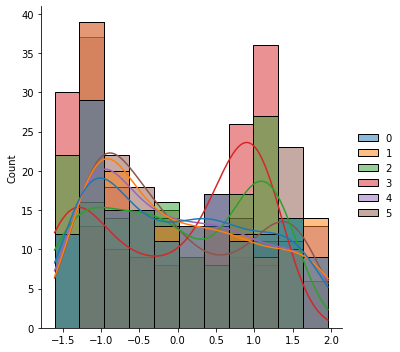

In [133]:
sns.displot(scaler_X1_aft_pt, kde = True)

min max scaling after normalization does make the plot distribution comply with the range dictated by the scaler. But it destroys the variance or spread that the normalizer had over the data.It's as if normalization wasn't done earlier; no difference between scaling only or normalizing then scaling. Therefore, it is best to choose either normalization or scaler that ensures that the data remains within the range of (-1, 1). Also, it is best this way b/c inverse transformation would be easier.

## Testing other normalizers (esp. those that are a variation of the power transformers)

In [134]:
norm= preprocessing.Normalizer() #-1,1 ? b/c 0,1 is slower learning but is ok to use for small sample size
norm_X1=norm.fit_transform(X1)  #didn't need to resize at all
norm_X1

array([[ 1.01669979e-01,  9.94773612e-01,  9.41685895e-03,
        -2.02901437e-07, -2.14303443e-07,  6.91281061e-09],
       [ 8.58334403e-02,  9.96257066e-01,  1.02214479e-02,
        -2.08400301e-07, -2.26056822e-07,  7.03021472e-09],
       [ 6.92466035e-02,  9.97538245e-01,  1.10615671e-02,
        -2.14004454e-07, -2.38436499e-07,  7.14272067e-09],
       [ 5.18578837e-02,  9.98583104e-01,  1.19392139e-02,
        -2.19722115e-07, -2.51487594e-07,  7.25001556e-09],
       [ 3.36105193e-02,  9.99352311e-01,  1.28565611e-02,
        -2.25561771e-07, -2.65259304e-07,  7.35173212e-09],
       [ 1.44421003e-02,  9.99800252e-01,  1.38159645e-02,
        -2.31532083e-07, -2.79805225e-07,  7.44743810e-09],
       [-5.71591072e-03,  9.99873840e-01,  1.48199689e-02,
        -2.37641742e-07, -2.95183705e-07,  7.53662202e-09],
       [-2.69386490e-02,  9.99511086e-01,  1.58713088e-02,
        -2.43899223e-07, -3.11458314e-07,  7.61867006e-09],
       [-4.93082687e-02,  9.98639382e-01,  1.697

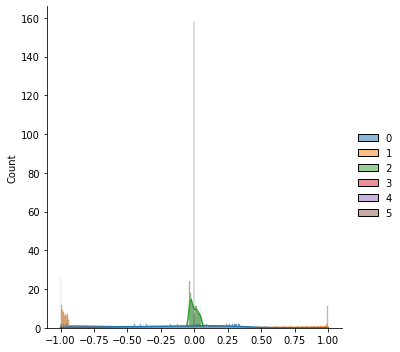

In [135]:
sns.displot(norm_X1, kde = True)

In [136]:
#Testing to see that the range was btwn (-1, 1):
print(norm_X1.min())
print(norm_X1.max())

-0.9998139902995716
0.999873840485299


the Normalizer by sklearn is within the range, but processes data per sample (or row-wise) of the data.

In [137]:
qt= preprocessing.QuantileTransformer() #-1,1 ? b/c 0,1 is slower learning but is ok to use for small sample size
qt_X1=qt.fit_transform(X1)  #didn't need to resize at all
qt_X1

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning:

n_quantiles (1000) is greater than the total number of samples (158). n_quantiles is set to n_samples.



array([[0.65605096, 1.        , 0.61783439, 0.08280255, 0.79617834,
        1.        ],
       [0.64968153, 0.99363057, 0.63057325, 0.07006369, 0.78343949,
        0.99363057],
       [0.63694268, 0.98726115, 0.63694268, 0.05732484, 0.77070064,
        0.98726115],
       [0.62420382, 0.98089172, 0.64968153, 0.03821656, 0.75796178,
        0.98089172],
       [0.61783439, 0.97452229, 0.66242038, 0.03184713, 0.7388535 ,
        0.97452229],
       [0.60509554, 0.96815287, 0.66878981, 0.01910828, 0.72611465,
        0.96815287],
       [0.59235669, 0.96178344, 0.68152866, 0.00636943, 0.7133758 ,
        0.96178344],
       [0.57961783, 0.95541401, 0.69426752, 0.        , 0.70063694,
        0.95541401],
       [0.56687898, 0.94904459, 0.70063694, 0.01273885, 0.68789809,
        0.94904459],
       [0.56050955, 0.94267516, 0.7133758 , 0.02547771, 0.67515924,
        0.94267516],
       [0.5477707 , 0.93630573, 0.72611465, 0.04458599, 0.66242038,
        0.93630573],
       [0.53503185, 0

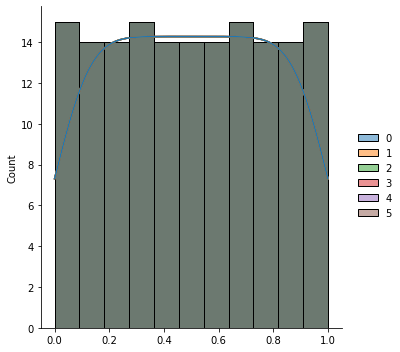

In [138]:
sns.displot(qt_X1, kde = True)

In [139]:
pca= PCA() #-1,1 ? b/c 0,1 is slower learning but is ok to use for small sample size
pca_X1=pca.fit_transform(X1)  #didn't need to resize at all
pca_X1

array([[ 3.48630249e+08,  1.07030992e+08, -2.39721443e+05,
         1.22664656e-01,  6.73096850e-02,  8.24260228e-05],
       [ 3.46821566e+08,  1.04025203e+08, -2.24014368e+05,
         1.09387026e-01,  5.67446547e-02,  1.41472855e-05],
       [ 3.44935544e+08,  1.00983345e+08, -2.08626397e+05,
         9.61840805e-02,  4.67799423e-02, -5.21775619e-05],
       [ 3.42971172e+08,  9.79076054e+07, -1.93563408e+05,
         8.30786647e-02,  3.74161859e-02, -1.16466347e-04],
       [ 3.40927501e+08,  9.48001979e+07, -1.78831012e+05,
         7.00938978e-02,  2.86555466e-02, -1.78608437e-04],
       [ 3.38803645e+08,  9.16633649e+07, -1.64434560e+05,
         5.72527726e-02,  2.05048178e-02, -2.38434253e-04],
       [ 3.36598780e+08,  8.84993738e+07, -1.50379131e+05,
         4.45793270e-02,  1.29833761e-02, -2.95623566e-04],
       [ 3.34312143e+08,  8.53105159e+07, -1.36669515e+05,
         3.21022960e-02,  6.14920728e-03, -3.49395343e-04],
       [ 3.31943024e+08,  8.20991043e+07, -1.233

In [140]:
#commented out b/c it took a long time to finish.
#sns.displot(pca_X1, kde = True)

## Using the sklearn 'normalize' fcn per feature of input and output.

In [141]:
normer_X1 = preprocessing.normalize(X1, axis = 0)
normer_X1

array([[ 1.36595323e-02,  3.42451936e-02,  1.08246484e-02,
        -7.67888065e-02, -4.54503678e-02,  3.47946205e-02],
       [ 1.12968014e-02,  3.35971673e-02,  1.15100187e-02,
        -7.72621901e-02, -4.69658026e-02,  3.46642583e-02],
       [ 8.92071840e-03,  3.29278354e-02,  1.21922161e-02,
        -7.76593701e-02, -4.84885555e-02,  3.44730230e-02],
       [ 6.53362673e-03,  3.22371037e-02,  1.28700402e-02,
        -7.79799583e-02, -5.00174161e-02,  3.42210095e-02],
       [ 4.13788082e-03,  3.15248951e-02,  1.35422932e-02,
        -7.82236272e-02, -5.15511714e-02,  3.39083595e-02],
       [ 1.73584421e-03,  3.07911494e-02,  1.42077803e-02,
        -7.83901080e-02, -5.30886110e-02,  3.35352568e-02],
       [-6.70112161e-04,  3.00358234e-02,  1.48653108e-02,
        -7.84791856e-02, -5.46285406e-02,  3.31019171e-02],
       [-3.07761133e-03,  2.92588902e-02,  1.55136983e-02,
        -7.84906772e-02, -5.61698217e-02,  3.26085491e-02],
       [-5.48427019e-03,  2.84603378e-02,  1.615

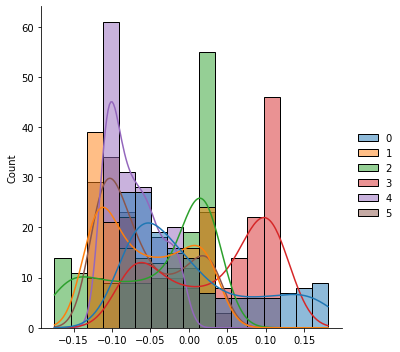

In [142]:
sns.displot(normer_X1, kde = True)

In [143]:
#Testing to see that the range was btwn (-1, 1):
print(normer_X1.min())
print(normer_X1.max())

-0.17482118289204746
0.18066564654060518


the normaliz fcn is similar to the mean normalization fcn, but with a smaller range. It is also called unit length normalization.

In [144]:
normer_Y1 = preprocessing.normalize(Y1, axis = 0)
normer_Y1

array([[ 7.11046618e-03,  8.85877796e-02,  1.14349818e-02,
        -6.95276801e-02, -7.60991579e-02,  4.55930120e-02],
       [ 5.88308539e-03,  8.69212478e-02,  1.21579082e-02,
        -6.96767181e-02, -7.77388834e-02,  4.52926044e-02],
       [ 4.65325252e-03,  8.52184161e-02,  1.28757521e-02,
        -6.98053059e-02, -7.94505518e-02,  4.49533482e-02],
       [ 3.42135505e-03,  8.34776731e-02,  1.35878624e-02,
        -6.99103259e-02, -8.12390752e-02,  4.45709527e-02],
       [ 2.18783948e-03,  8.16972964e-02,  1.42935148e-02,
        -6.99881859e-02, -8.31097975e-02,  4.41405589e-02],
       [ 9.53220443e-04,  7.98754430e-02,  1.49919029e-02,
        -7.00347371e-02, -8.50685419e-02,  4.36566471e-02],
       [-2.81908651e-04,  7.80101374e-02,  1.56821263e-02,
        -7.00451734e-02, -8.71216691e-02,  4.31129232e-02],
       [-1.51686294e-03,  7.60992604e-02,  1.63631777e-02,
        -7.00139055e-02, -8.92761713e-02,  4.25021653e-02],
       [-2.75085084e-03,  7.41405321e-02,  1.703

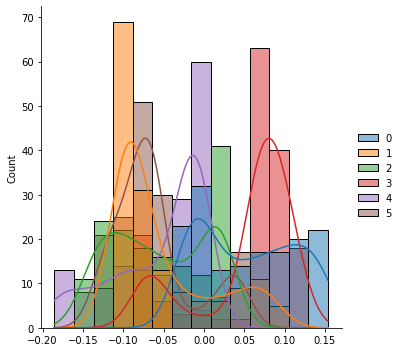

In [145]:
sns.displot(normer_Y1, kde=True)

In [146]:
#Testing to see that the range was btwn (-1, 1):
print(normer_Y1.min())
print(normer_Y1.max())

-0.18527080340848084
0.15364916057337033


#Reshape data for LSTM to 3D : (#samples, #timesteps, #features).

Reshaping Training, Validation, and Test Data for LSTM

In [147]:
norm_X1_in_train=np.resize(mnm_X1,(158,1,6))  #Only resizing the X normalized training parts (samples, time step, features)
norm_X1_in_train

array([[[ 0.0295853 ,  0.56947221,  0.26446045, -0.57186321,
          0.27133685,  0.61576141]],

       [[ 0.02043393,  0.56546894,  0.26788175, -0.57429735,
          0.2565298 ,  0.61491132]],

       [[ 0.01123084,  0.56133405,  0.27128721, -0.57633965,
          0.24165125,  0.61366429]],

       [[ 0.00198512,  0.55706696,  0.27467084, -0.57798811,
          0.22671303,  0.61202092]],

       [[-0.00729413,  0.55266719,  0.27802666, -0.57924106,
          0.21172697,  0.60998215]],

       [[-0.01659774,  0.54813437,  0.28134871, -0.5800971 ,
          0.19670492,  0.60754917]],

       [[-0.02591653,  0.54346824,  0.28463103, -0.58055514,
          0.18165854,  0.60472339]],

       [[-0.0352413 ,  0.53866863,  0.28786772, -0.58061423,
          0.16659896,  0.60150616]],

       [[-0.04456282,  0.53373546,  0.29105285, -0.58027305,
          0.15153501,  0.59789761]],

       [[-0.05387177,  0.52866869,  0.29418047, -0.57952289,
          0.13645712,  0.59388278]],

       [[-

In [148]:
norm_Y1_out_train=np.resize(mnm_Y1,(158,1,6))  #Only resizing the X scaled training parts
norm_Y1_out_train

array([[[-2.59098253e-01,  7.43438881e-01,  3.85743776e-01,
         -6.54794573e-01, -1.10854399e-01,  6.17765813e-01]],

       [[-2.65929985e-01,  7.34670819e-01,  3.89969358e-01,
         -6.55593841e-01, -1.19801156e-01,  6.16053343e-01]],

       [[-2.72775366e-01,  7.25711774e-01,  3.94165233e-01,
         -6.56283439e-01, -1.29140452e-01,  6.14119417e-01]],

       [[-2.79632238e-01,  7.16553267e-01,  3.98327594e-01,
         -6.56846645e-01, -1.38899088e-01,  6.11939576e-01]],

       [[-2.86498117e-01,  7.07186237e-01,  4.02452208e-01,
         -6.57264196e-01, -1.49106222e-01,  6.09486121e-01]],

       [[-2.93370138e-01,  6.97600987e-01,  4.06534361e-01,
         -6.57513843e-01, -1.59793626e-01,  6.06727588e-01]],

       [[-3.00244998e-01,  6.87787124e-01,  4.10568791e-01,
         -6.57569811e-01, -1.70996007e-01,  6.03628097e-01]],

       [[-3.07118885e-01,  6.77733497e-01,  4.14549610e-01,
         -6.57402127e-01, -1.82751516e-01,  6.00146478e-01]],

       [[-3.1398

In [149]:
norm_Y1_out_train.shape

(158, 1, 6)

In [150]:
norm_X2_in_val=np.resize(mnm_X2,(158,1,6))  #Only resizing the X scaled training parts (samples, time step, features)
norm_X2_in_val

array([[[-0.16490641,  0.62025378,  0.35166073, -0.6187913 ,
          0.10509837,  0.63989785]],

       [[-0.17149031,  0.61500983,  0.35384517, -0.61765411,
          0.09078125,  0.63543258]],

       [[-0.1780487 ,  0.60960865,  0.35596858, -0.61611867,
          0.07649946,  0.63057982]],

       [[-0.18457398,  0.60405072,  0.35802592, -0.61418593,
          0.0622645 ,  0.62534316]],

       [[-0.19105857,  0.59833659,  0.36001217, -0.61185715,
          0.0480878 ,  0.61972651]],

       [[-0.19749493,  0.59246699,  0.36192239, -0.60913388,
          0.03398064,  0.613734  ]],

       [[-0.20387553,  0.58644272,  0.36375168, -0.6060179 ,
          0.01995401,  0.60736986]],

       [[-0.21019291,  0.58026474,  0.36549521, -0.60251101,
          0.00601812,  0.60063804]],

       [[-0.2164396 ,  0.57393409,  0.36714817, -0.598614  ,
         -0.00781974,  0.59354011]],

       [[-0.2226081 ,  0.56745181,  0.36870568, -0.59431423,
         -0.02157665,  0.58605146]],

       [[-

In [151]:
norm_Y2_out_val=np.resize(mnm_Y2,(158,1,6))  #Only resizing the X scaled training parts (samples, time step, features)
norm_Y2_out_val

array([[[-2.86433318e-01,  7.24513692e-01,  4.23787071e-01,
         -7.08592480e-01, -1.55576088e-01,  6.53053833e-01]],

       [[-2.92593066e-01,  7.15414944e-01,  4.26724605e-01,
         -7.07224336e-01, -1.66253504e-01,  6.48344369e-01]],

       [[-2.98728359e-01,  7.06131203e-01,  4.29594105e-01,
         -7.05602709e-01, -1.77321915e-01,  6.43257807e-01]],

       [[-3.04834824e-01,  6.96655650e-01,  4.32390100e-01,
         -7.03700276e-01, -1.88800797e-01,  6.37760562e-01]],

       [[-3.10907616e-01,  6.86981129e-01,  4.35106628e-01,
         -7.01486438e-01, -2.00710468e-01,  6.31815487e-01]],

       [[-3.16941357e-01,  6.77100131e-01,  4.37737184e-01,
         -6.98926875e-01, -2.13072065e-01,  6.25381411e-01]],

       [[-3.22930073e-01,  6.67004780e-01,  4.40274660e-01,
         -6.95983005e-01, -2.25907563e-01,  6.18412576e-01]],

       [[-3.28867120e-01,  6.56686817e-01,  4.42711276e-01,
         -6.92611297e-01, -2.39239992e-01,  6.10857798e-01]],

       [[-3.3474

In [152]:
norm_Y2_out_val.shape

(158, 1, 6)

In [153]:
norm_X3_in_test=np.resize(mnm_X3,(158,1,6))  #Only resizing the X scaled val parts (samples, time step, features)
norm_X3_in_test

array([[[-2.99896944e-01,  6.72018386e-01,  4.23204546e-01,
         -6.43042946e-01, -7.29982369e-02,  6.44947223e-01]],

       [[-3.04617765e-01,  6.64871150e-01,  4.24252309e-01,
         -6.37864387e-01, -8.62286828e-02,  6.36334081e-01]],

       [[-3.09250195e-01,  6.57540551e-01,  4.25199251e-01,
         -6.32301562e-01, -9.93128857e-02,  6.27364525e-01]],

       [[-3.13787947e-01,  6.50028700e-01,  4.26041323e-01,
         -6.26358789e-01, -1.12240253e-01,  6.18045606e-01]],

       [[-3.18224805e-01,  6.42337856e-01,  4.26774562e-01,
         -6.20040671e-01, -1.25000383e-01,  6.08384600e-01]],

       [[-3.22554631e-01,  6.34470419e-01,  4.27395087e-01,
         -6.13352044e-01, -1.37583147e-01,  5.98388916e-01]],

       [[-3.26771368e-01,  6.26428931e-01,  4.27899102e-01,
         -6.06297856e-01, -1.49978887e-01,  5.88065864e-01]],

       [[-3.30869041e-01,  6.18216058e-01,  4.28282892e-01,
         -5.98882757e-01, -1.62179054e-01,  5.77421879e-01]],

       [[-3.3484

In [154]:
norm_Y3_out_test=np.resize(mnm_Y3,(158,1,6))  #Only resizing the X scaled val parts (samples, time step, features)
norm_Y3_out_test

array([[[-2.59098253e-01,  7.43438881e-01,  3.85743776e-01,
         -6.54794573e-01, -1.10854399e-01,  6.17765813e-01]],

       [[-2.65929985e-01,  7.34670819e-01,  3.89969358e-01,
         -6.55593841e-01, -1.19801156e-01,  6.16053343e-01]],

       [[-2.72775366e-01,  7.25711774e-01,  3.94165233e-01,
         -6.56283439e-01, -1.29140452e-01,  6.14119417e-01]],

       [[-2.79632238e-01,  7.16553267e-01,  3.98327594e-01,
         -6.56846645e-01, -1.38899088e-01,  6.11939576e-01]],

       [[-2.86498117e-01,  7.07186237e-01,  4.02452208e-01,
         -6.57264196e-01, -1.49106222e-01,  6.09486121e-01]],

       [[-2.93370138e-01,  6.97600987e-01,  4.06534361e-01,
         -6.57513843e-01, -1.59793626e-01,  6.06727588e-01]],

       [[-3.00244998e-01,  6.87787124e-01,  4.10568791e-01,
         -6.57569811e-01, -1.70996007e-01,  6.03628097e-01]],

       [[-3.07118885e-01,  6.77733497e-01,  4.14549610e-01,
         -6.57402127e-01, -1.82751516e-01,  6.00146478e-01]],

       [[-3.1398

In [155]:
norm_Y3_out_test.shape

(158, 1, 6)

# Creating Model

word of thumb: num of cells is btwn num training samples and num of features

In [156]:
#lstm
#def create_model(): -this is for the functional model-
#using the sequential model instead
model=keras.models.Sequential([
                                  #there's a diff btwn LSTMCell() and LSTM(), the latter uses CuDNN whilst the other doesn't.
                #1st layer is the input layer, which shape is defined in the next layer
                  #keras.layers.LSTM(15, input_shape=(1,3), activation='relu', return_sequences = True),
                  keras.layers.LSTM(6, input_shape=(1,6), activation='tanh', recurrent_activation= 'tanh', bias_initializer='zeros', kernel_initializer='glorot_uniform', recurrent_initializer='glorot_uniform', stateful=False, return_sequences=True, return_state=False), #activity_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),kernel_regularizer=L2(0.01), 1st hidden layer, so this is 2nd layer
                  
                  keras.layers.LSTM(5, activation='tanh', recurrent_activation='tanh', bias_initializer='zeros', kernel_initializer='glorot_uniform', recurrent_initializer='glorot_uniform', stateful=False, return_sequences=True, return_state=False ), #kernel_regularizer=L2(0.01), 2nd hidden layer, so this is 3nd layer
                  
                  keras.layers.TimeDistributed(Dense(6)) # activation='softmax'  #Output, softmax is loss probability between estimated and truth label btwn layers
                 
])

#model.compile(Adam(lr=.0001),loss='mean_squared_error',metrics=['accuracy'])
#return model

In [157]:
model.compile(Adam(learning_rate=.0009), loss='mse', metrics=['accuracy']) # using optimizer = Adam; metrics=[tf.keras.metrics.Accuracy()])

In [158]:
#model.compile(Adam(lr=.001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.01, amsgrad=False), loss='mse', metrics=['accuracy']) # decay=0.01, metrics=[tf.keras.metrics.Accuracy()]) # metrics measures the accuracy and needs to be corrected 

In [159]:
#need to define the decay function to use in model.compile
#alpha_0= 0.01   #initial learning rate
#will be using the inverse sqrt
#batch_samples= 1010   #need to define the # of samples per batch for the equation below [batch samples = batch_size in model.fit]
#decay_1 = 1/sqrt(normalized_X_train.shape[0]/batch_samples)    # the 0th dimension is the # of samples / batch's number of samples = # of iterations
#learning_rate = alpha_0 *(decay_1) 
#batch_samples, learning_rate, decay_1   #prints out the current values of both parameters created

In [160]:
#Going to try different decay schedules instead
#alpha_t = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.1, decay_steps= 1.0, decay_rate=0.5, staircase= False)

In [161]:
#model.compile(SGD(learning_rate = alpha_t, momentum=0.5, nesterov = True), loss='mse', metrics=['accuracy'])

In [162]:
#Creates a basic model instance
#model= create_model()

In [163]:
#Display's model architecture
#model.build(input_shape = (None,5,3))   #had to add this for bidirectional wrapper
# Param # is the # of weights + biases per layer
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 6)              312       
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 5)              240       
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 6)              36        
Total params: 588
Trainable params: 588
Non-trainable params: 0
_________________________________________________________________


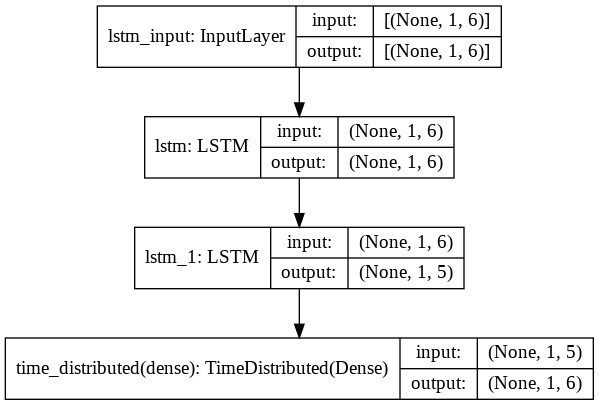

In [164]:
#can visualize network topology
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [165]:
#Using the anti-Plateau Scheduler - by Keras (a.k.a ReduceLROnPlateau )
# the argument 'decay' in model.compile has a default formula wrt lr where:
#lr = initial_lr * (1.0/(1 + decay * iterations)) ; the term 'iterations is
#a bit tricky where iterations =  epochs if # of samples/batch_size = 1
# but if not then, the 'iterations' part of the eqn becomes: 
# (epoch * iterations)
#anyways, back to the Scheduler:
#RedPlat_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.01, patience = 10, verbose = 0, mode = "auto", min_delta = 0.000001, cooldown = 0, min_lr = 0)

In [166]:
#RedPlat_callback2 = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.01, patience = 5, verbose = 0, mode = "max", min_delta = 0.000001, cooldown = 0, min_lr = 0)

stops code right before overfitting overtakes the training process

In [167]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)    #can change what it monitors; stops training once overfitting occurs

batch size = # of samples per iteration, epochs = # of passes over the whole dataset, iteration = # of passes (forward+backward passes) per epoch...for ex:1000 trainining samples at 500 samples per batch, will have 2 iterations per epoch.

In [168]:
history=model.fit(norm_X1_in_train,norm_Y1_out_train, batch_size= 21 , epochs=1000, validation_data=(norm_X2_in_val, norm_Y2_out_val), validation_batch_size = 21, callbacks= [es_callback], validation_freq= 1, shuffle=False, verbose=2 )  #callbacks=[es_callback], can also use validation_data in lieu of validation_split

Epoch 1/1000
8/8 - 27s - loss: 0.0999 - accuracy: 0.1456 - val_loss: 0.1013 - val_accuracy: 0.1709
Epoch 2/1000
8/8 - 0s - loss: 0.0994 - accuracy: 0.1456 - val_loss: 0.1013 - val_accuracy: 0.1709
Epoch 3/1000
8/8 - 0s - loss: 0.0993 - accuracy: 0.1456 - val_loss: 0.1013 - val_accuracy: 0.1709
Epoch 4/1000
8/8 - 0s - loss: 0.0993 - accuracy: 0.1456 - val_loss: 0.1013 - val_accuracy: 0.1709
Epoch 5/1000
8/8 - 0s - loss: 0.0993 - accuracy: 0.1456 - val_loss: 0.1013 - val_accuracy: 0.1709
Epoch 6/1000
8/8 - 0s - loss: 0.0993 - accuracy: 0.0190 - val_loss: 0.1013 - val_accuracy: 0.0000e+00
Epoch 7/1000
8/8 - 0s - loss: 0.0993 - accuracy: 0.0000e+00 - val_loss: 0.1013 - val_accuracy: 0.0000e+00
Epoch 8/1000
8/8 - 0s - loss: 0.0993 - accuracy: 0.0000e+00 - val_loss: 0.1013 - val_accuracy: 0.0000e+00
Epoch 9/1000
8/8 - 0s - loss: 0.0993 - accuracy: 0.0000e+00 - val_loss: 0.1013 - val_accuracy: 0.0000e+00
Epoch 10/1000
8/8 - 0s - loss: 0.0993 - accuracy: 0.0000e+00 - val_loss: 0.1012 - val_acc

if training accuracy > > validation accuracy then model overfitted. /n,
training accuracy must be > validation accuracy /n,
validation accuracy and accuracy measures system's performance in general /n,
training loss must be > validation loss

We want training accuracy > validation accuracy and training loss < validation loss

In [169]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

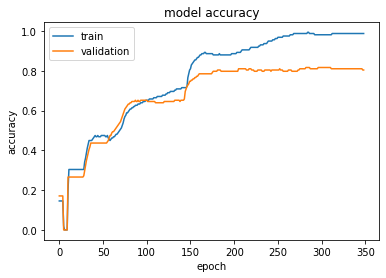

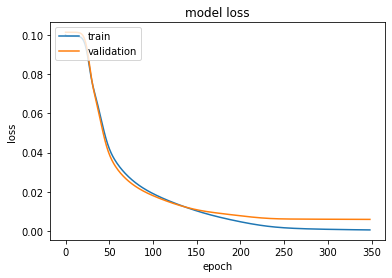

In [170]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

history.history.get gives final epoch's training accuracy

In [171]:
history.history.get('accuracy')[-1]

0.9873417615890503

this e func below lists out the test loss and test accuracy from the final epoch

In [172]:
e = model.evaluate(
    x=norm_X3_in_test,
    y=norm_Y3_out_test,
    verbose=1
)

e = {out: e[i] for i, out in enumerate(model.metrics_names)}

5/5 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.6519


model.evaluate requires the test set to be used  and spits out its accuracy and loss

In [173]:
model.evaluate(norm_X3_in_test,norm_Y3_out_test, return_dict= True, batch_size= 21, verbose=3)   #need to add in accuracy arg. ; accuracy value only works when model.fit contains validation_data not ''_split

{'accuracy': 0.6518987417221069, 'loss': 0.02758786641061306}

below code gives the accuracy in % when the prediction values for any data set is compared to its true labels. It is a classification accuracy score.
In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

In [174]:

Y_pred = model.predict(norm_X1_in_train)
#Converting predictions to label
pred = list()   #predicted output values from model (1-D array)
for i in range(len(Y_pred)):
    pred.append(np.argmax(Y_pred[i]))
#Converting one hot encoded test label to label
true = list()   #list of y_true labels (1-D array)
for i in range(len(norm_Y1_out_train)):
    true.append(np.argmax(norm_Y1_out_train[i]))

In [175]:
from sklearn.metrics import accuracy_score
a = accuracy_score(y_true= true, y_pred= pred)
print('Prediction Accuracy is:', a*100)

Prediction Accuracy is: 98.73417721518987


In [176]:
#lists out the predicted norm values
training_data= norm_X1_in_train 
test_input=training_data
test_output = model.predict(test_input, verbose=0)
test_output

array([[[-0.28898466,  0.70050395,  0.40438306, -0.71759737,
         -0.12165617,  0.66688776]],

       [[-0.28976694,  0.6981766 ,  0.40460002, -0.71606064,
         -0.12589312,  0.66421616]],

       [[-0.2909016 ,  0.69548166,  0.40505958, -0.7142267 ,
         -0.13117108,  0.66100323]],

       [[-0.29240042,  0.6924037 ,  0.40576738, -0.71207285,
         -0.13752438,  0.657218  ]],

       [[-0.29427606,  0.68892515,  0.40672895, -0.70957386,
         -0.14498979,  0.65282506]],

       [[-0.2965423 ,  0.68502665,  0.4079502 , -0.7067003 ,
         -0.15360616,  0.6477846 ]],

       [[-0.2992134 ,  0.6806859 ,  0.40943646, -0.70341897,
         -0.16341424,  0.64205146]],

       [[-0.30230445,  0.6758778 ,  0.41119254, -0.6996919 ,
         -0.17445575,  0.63557446]],

       [[-0.30583173,  0.6705735 ,  0.4132231 , -0.69547546,
         -0.18677418,  0.628295  ]],

       [[-0.30982178,  0.66472924,  0.41553855, -0.6907108 ,
         -0.20043933,  0.62013173]],

       [[-

In [177]:
test_output.shape

(158, 1, 6)

# Interpreting Weights and Getting Estimated Label Values

In [178]:
# Way to create an equation 
#https://stackoverflow.com/questions/17510098/deriving-equation-by-weights-and-biases-from-a-neural-network
# http://deeplearning.net/tutorial/lstm.html
# https://fairyonice.github.io/Extract-weights-from-Keras's-LSTM-and-calcualte-hidden-and-cell-states.html
#https://medium.com/deep-learning-with-keras/lstm-understanding-the-number-of-parameters-c4e087575756

visualize 'W' as the branches between layes, 'U' as the weights for each node within a layer, and biases as additional units on each node within a layer except for the output. 

In [179]:
MODEL_W_U_b= model.get_weights()
MODEL_W_U_b

[array([[ 0.38292703,  0.21870746,  0.5234968 , -0.3483136 ,  0.37978142,
          0.12012707, -0.28502905, -0.12900186,  0.31179446, -0.33439577,
         -0.41972038,  0.19894063, -0.08586376,  0.3879411 , -0.8843834 ,
          0.41305712,  0.5689187 ,  0.14557415, -0.18623134, -0.10230129,
          0.76053965,  0.25993904, -0.5024404 ,  0.35000253],
        [-0.80139554, -0.80912995, -0.77348924,  0.67261195, -0.73734605,
         -0.5047196 , -0.09035823,  0.32743728,  0.12935734, -0.36225152,
          0.08280921, -0.09913391,  0.83206457,  0.10866358, -0.22698271,
         -0.4614458 , -0.99065524,  0.49982452,  0.6237328 ,  0.58881617,
         -0.8095711 , -0.21800803, -0.61260355, -0.4272537 ],
        [ 0.04089021, -0.9993355 , -0.65839696,  0.12667365, -0.87015635,
         -0.5500224 , -0.2631817 ,  0.4002421 , -0.04337806,  0.21475464,
         -0.09414443,  0.15078044, -0.01527202,  0.4152722 ,  0.07875013,
         -0.36821842, -0.54608756,  0.14341356,  0.01022952, -

In [180]:
print("Number of weights after calling the model:", len(model.weights))  #this actually includes biases. So, the biases are also calculated in as 'weights'. Thus, some of the arrays are actually biases

Number of weights after calling the model: 8


Now, getting the weights (W and U) and biases separately. Remember, that W is the weights per gate and U is the recurrent weights per gate. 

In [181]:
W1= model.layers[0].get_weights()[0]  #can also use layer.get_weights, this is weights for the 1st hidden layer
W1

array([[ 0.38292703,  0.21870746,  0.5234968 , -0.3483136 ,  0.37978142,
         0.12012707, -0.28502905, -0.12900186,  0.31179446, -0.33439577,
        -0.41972038,  0.19894063, -0.08586376,  0.3879411 , -0.8843834 ,
         0.41305712,  0.5689187 ,  0.14557415, -0.18623134, -0.10230129,
         0.76053965,  0.25993904, -0.5024404 ,  0.35000253],
       [-0.80139554, -0.80912995, -0.77348924,  0.67261195, -0.73734605,
        -0.5047196 , -0.09035823,  0.32743728,  0.12935734, -0.36225152,
         0.08280921, -0.09913391,  0.83206457,  0.10866358, -0.22698271,
        -0.4614458 , -0.99065524,  0.49982452,  0.6237328 ,  0.58881617,
        -0.8095711 , -0.21800803, -0.61260355, -0.4272537 ],
       [ 0.04089021, -0.9993355 , -0.65839696,  0.12667365, -0.87015635,
        -0.5500224 , -0.2631817 ,  0.4002421 , -0.04337806,  0.21475464,
        -0.09414443,  0.15078044, -0.01527202,  0.4152722 ,  0.07875013,
        -0.36821842, -0.54608756,  0.14341356,  0.01022952, -0.11686227,
  

In [182]:
W1.shape #( # input units, #units of 1st hidden layer x4),  b/c input layer will have 6 units, since # features = 6

(6, 24)

In [183]:
U1= model.layers[0].get_weights()[1]  # this is to get the recurrent weights for the 1st hidden layer
U1

array([[-0.18288165, -0.01982856, -0.07985851, -0.3245419 ,  0.23628867,
        -0.3691422 , -0.34726807,  0.2695223 , -0.1639677 , -0.40842056,
         0.04088914, -0.27242056, -0.18749079, -0.27863395,  0.33211923,
        -0.26687247, -0.12587264, -0.10803583,  0.08802295,  0.07961297,
         0.02090898,  0.35499084, -0.35673958,  0.00620839],
       [-0.0506219 ,  0.0848034 , -0.24726197,  0.16624308, -0.4091519 ,
         0.17462486, -0.44588763, -0.30448806, -0.00206786,  0.00381768,
         0.4395554 , -0.30743098,  0.42691368, -0.33735874,  0.12376332,
        -0.40577054,  0.22846383, -0.39736983, -0.42899516,  0.05572009,
         0.42669463,  0.16777354,  0.35692692,  0.12989897],
       [-0.19668573,  0.04027137,  0.02538601,  0.28384477, -0.1052168 ,
         0.0018093 ,  0.08514154,  0.25001854, -0.3445819 , -0.4119896 ,
        -0.23339777, -0.09106523, -0.37280366,  0.19621444,  0.11319077,
         0.41345644,  0.41626108,  0.2828098 ,  0.00495142, -0.2861196 ,
  

In [184]:
U1.shape  # (6, 6x4) = (#units, units x gates)

(6, 24)

In [185]:
biases1= model.layers[0].get_weights()[2]  #biases for the 1st layer, which happens to be be the 1st hidden LSTM layer
biases1

array([ 0.44490308, -0.215109  , -0.01537277, -0.33941868, -0.29670826,
        0.4818035 ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        , -0.45703232,  0.340538  , -0.06341505,
        0.3301699 , -0.30261973, -0.38821852, -0.2932175 ,  0.4855438 ,
       -0.19085652,  0.23462754, -0.4324219 ,  0.36127272], dtype=float32)

In [186]:
biases1.shape # 6 (units) x 4(gates) = 24

(24,)

In [187]:
W2= model.layers[1].get_weights()[0]  # this is weights for the 2nd layer, 

In [188]:
W2.shape # 6 units in 1st hidden layer, each gate has a list of weights. There are 4 gates. And each unit (there are 5 units in 2nd hidden layer) will have each of its 4 gates a weight. so (6, 20)

(6, 20)

In [189]:
U2= model.layers[1].get_weights()[1]  # this is to get the recurrent weights for the 2nd hidden LSTM layer
U2

array([[-0.359219  , -0.11123616, -0.14919278, -0.02443823,  0.13420656,
        -0.48391983, -0.29964733, -0.2832344 ,  0.3494101 ,  0.24824265,
         0.40769884, -0.44031426,  0.07946274,  0.24542424, -0.41433555,
         0.27749023,  0.1143823 , -0.13343263, -0.36069492, -0.29645836],
       [-0.37341356, -0.02172121,  0.33063772, -0.43051142, -0.23995596,
         0.34254572, -0.04931727, -0.14359778, -0.35440776, -0.152441  ,
         0.27942994,  0.01494429, -0.13237044,  0.18124875, -0.2639292 ,
        -0.19840619,  0.2934192 , -0.07039371, -0.24915321,  0.3140144 ],
       [-0.15658894, -0.20988876,  0.1463224 ,  0.2115685 ,  0.07016316,
        -0.09302703, -0.35669985,  0.18944594,  0.37234285,  0.3759623 ,
        -0.26011917, -0.15627488, -0.25093383, -0.35831535,  0.16317746,
        -0.4738049 , -0.05006325,  0.19124946,  0.34449396,  0.32275805],
       [ 0.22443208,  0.0423356 , -0.3397655 , -0.187962  ,  0.25764814,
        -0.24077031, -0.06334925,  0.12510344, -

In [190]:
U2.shape  # 5 units and 4 gates in each unit. (5, 5 x 4) = (5, 20)

(5, 20)

In [191]:
biases2= model.layers[1].get_weights()[2]  #biases for the 2nd layer, which happens to be be the 2nd hidden LSTM layer
biases2

array([ 0.40713423,  0.12177181, -0.2792909 , -0.01743388, -0.3541646 ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
       -0.3959542 , -0.43185318, -0.66078365, -0.46544364,  0.07261855,
       -0.3218172 , -0.48771715,  0.6618449 ,  0.49908656,  0.2380691 ],
      dtype=float32)

In [192]:
biases2.shape # 5 x 4 = 20, where 5 is the # of units in 2nd hidden layer and 4 is the # of gates.

(20,)

In [193]:
W3= model.layers[2].get_weights()[0]  # this is weights for the output layer
W3

array([[ 0.56349754, -0.85305274, -0.5928075 , -0.46247706,  0.33894408,
         0.07621783],
       [ 0.57223046, -0.4464028 , -0.49064454,  1.1244112 ,  0.36564162,
        -0.12733418],
       [ 0.27068514, -0.07450858, -0.2729118 ,  0.02871548,  1.6114675 ,
        -0.02542032],
       [-0.99123544,  0.09342691,  0.94851667,  0.3805683 , -0.08684964,
        -0.4669712 ],
       [-0.15910898,  0.63019776,  0.4636239 , -0.2021688 , -0.34025475,
         1.0853608 ]], dtype=float32)

In [194]:
W3.shape  # 5 units in the 2nd hidden layer, and the input and output shapes are (1, 6), since this is a one-to-one seq2seq prediction, thus output layer has 6 units.

(5, 6)

In [195]:
U3= model.layers[2].get_weights()[1]  # this is to get the recurrent weights for the output layer
U3

array([-0.22980379, -0.00535843,  0.19338782,  0.26227662, -0.15601505,
       -0.25798267], dtype=float32)

In [196]:
U3.shape  #there are 6 units in the output layer ;(it is a dense or fully connected (FC) layer, so no gates)

(6,)

In [197]:
#there are no biases in the output layer

## Plotting the Weights (to see valid connections to solar perturbations)

Text(0.5, 1.0, 'biases1')

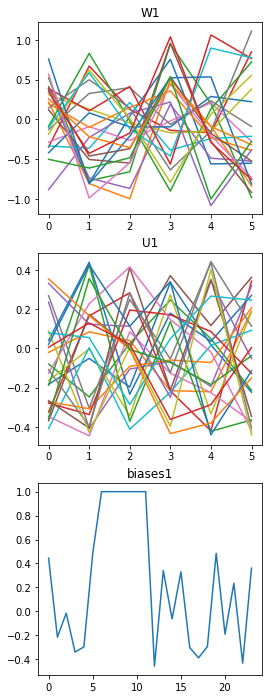

In [198]:
fig15 = plt.figure(figsize= plt.figaspect(3,))
ax15 = fig15.add_subplot(311)
ax15.plot(W1)
plt.title('W1')

ax16 = fig15.add_subplot(312)
ax16.plot(U1)
plt.title('U1')

ax17 = fig15.add_subplot(313)
ax17.plot(biases1)
plt.title('biases1')


Text(0.5, 1.0, 'biases2')

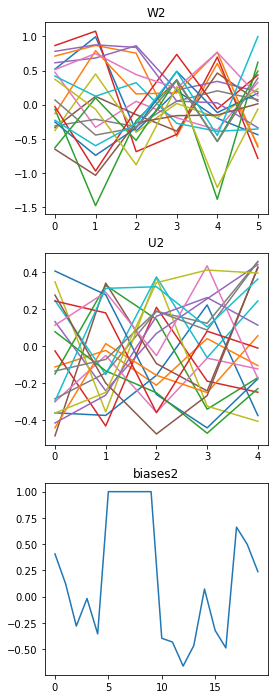

In [199]:
fig18 = plt.figure(figsize= plt.figaspect(3,))      #want 3 figures or subplot figures
ax18 = fig18.add_subplot(311)                       # 3 figures, total, 1 column, 1st subplot
ax18.plot(W2)
plt.title('W2')

ax19 = fig18.add_subplot(312)                      # 3 figures total, 1 column, 2nd subplot
ax19.plot(U2)
plt.title('U2')

ax20 = fig18.add_subplot(313)                     # 3 figures total, 1 column, 3rd subplot
ax20.plot(biases2)
plt.title('biases2')

Text(0.5, 1.0, 'U3')

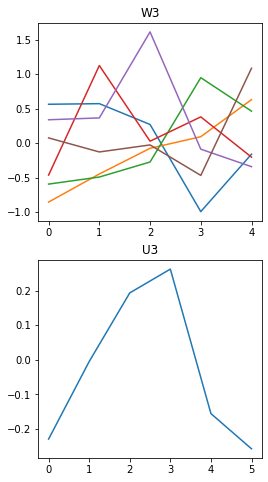

In [200]:
fig21 = plt.figure(figsize= plt.figaspect(2,))
ax21 = fig21.add_subplot(2,1,1)
ax21.plot(W3)
plt.title('W3')

ax22 = fig21.add_subplot(2,1,2)
ax22.plot(U3)
plt.title('U3')

#Plotting the Perturbations

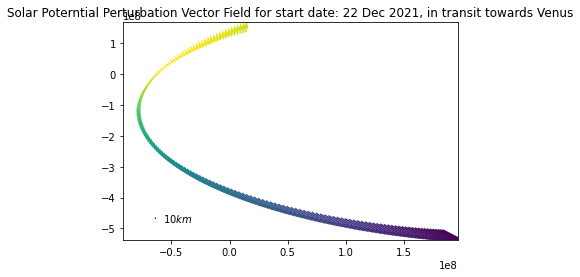

In [201]:
fig10, ax10 = plt.subplots()
#plt.figure(figsize=(20,20)) 
ax10.set_title('Solar Poterntial Perturbation Vector Field for start date: 22 Dec 2021, in transit towards Venus')
#Q = ax1.quiver(X, Y, Wx, Wy, Wz, units='width', pivot="tail")  #were X and Y represent the base of location of an arrow on XY-plane (2D) and Wx, Wy and Wz are the cartesian
                                                                #coordinates that direct where the quiver(arrow) is expected to point at.
Q = ax10.quiver(X1[:,0], X1[:,1], Y1[:,0],Y1[:,1],Y1[:,2])  
 #Remember, it is a 2D plane, so only the U.X and U.Y components are to be considered for the base,
# but for the vector itself, can use depth to validate its direction. And prefer that the arrow starts from the unperturbed curve to the
# perturbed curve. The 'Z' coordinate component is defined via color, darker colors represent negative while warmer ones represent positive.
qk = ax10.quiverkey(Q, 0.2, 0.2, 0.9, r'$10 {km}$', labelpos='E',
                   coordinates='figure')

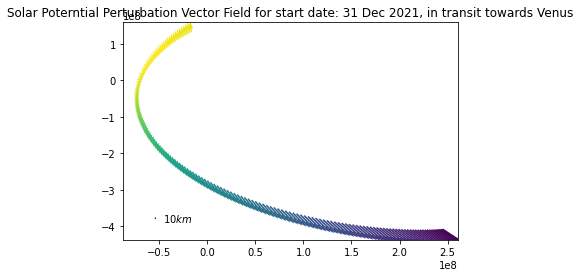

In [202]:
fig11, ax11 = plt.subplots()
#plt.figure(figsize=(20,20)) 
ax11.set_title('Solar Poterntial Perturbation Vector Field for start date: 31 Dec 2021, in transit towards Venus')
#Q = ax1.quiver(X, Y, Wx, Wy, Wz, units='width', pivot="tail")  #were X and Y represent the base of location of an arrow on XY-plane (2D) and Wx, Wy and Wz are the cartesian
                                                                #coordinates that direct where the quiver(arrow) is expected to point at.
Q = ax11.quiver(X2[:,0], X2[:,1], Y2[:,0],Y2[:,1],Y2[:,2])  
 #Remember, it is a 2D plane, so only the U.X and U.Y components are to be considered for the base,
# but for the vector itself, can use depth to validate its direction. And prefer that the arrow starts from the unperturbed curve to the
# perturbed curve. The 'Z' coordinate component is defined via color, darker colors represent negative while warmer ones represent positive.
qk = ax11.quiverkey(Q, 0.2, 0.2, 0.9, r'$10 {km}$', labelpos='E',
                   coordinates='figure')

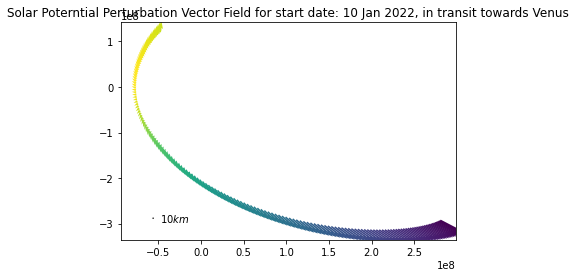

In [203]:
fig12, ax12 = plt.subplots()
#plt.figure(figsize=(20,20)) 
ax12.set_title('Solar Poterntial Perturbation Vector Field for start date: 10 Jan 2022, in transit towards Venus')
#Q = ax1.quiver(X, Y, Wx, Wy, Wz, units='width', pivot="tail", width = #)  #were X and Y represent the base of location of an arrow on XY-plane (2D) and Wx, Wy and Wz are the cartesian
                                                                #coordinates that direct where the quiver(arrow) is expected to point at.
Q = ax12.quiver(X3[:,0], X3[:,1], Y3[:,0],Y3[:,1],Y3[:,2])  
 #Remember, it is a 2D plane, so only the U.X and U.Y components are to be considered for the base,
# but for the vector itself, can use depth to validate its direction. And prefer that the arrow starts from the unperturbed curve to the
# perturbed curve. The 'Z' coordinate component is defined via color, darker colors represent negative while warmer ones represent positive.
qk = ax12.quiverkey(Q, 0.2, 0.2, 0.9, r'$10 {km}$', labelpos='E',
                   coordinates='figure')

## Testing with velocities 

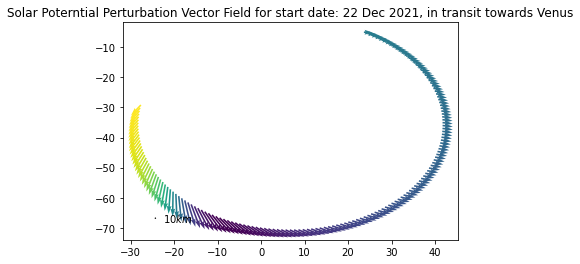

In [204]:
fig30, ax30 = plt.subplots()
#plt.figure(figsize=(20,20)) 
ax30.set_title('Solar Poterntial Perturbation Vector Field for start date: 22 Dec 2021, in transit towards Venus')
#Q = ax1.quiver(X, Y, Wx, Wy, Wz, units='width', pivot="tail")  #were X and Y represent the base of location of an arrow on XY-plane (2D) and Wx, Wy and Wz are the cartesian
                                                                #coordinates that direct where the quiver(arrow) is expected to point at.
Q = ax30.quiver(X1[:,3], X1[:,4], Y1[:,3],Y1[:,4],Y1[:,5])  
 #Remember, it is a 2D plane, so only the U.VX and U.VY components are to be considered for the base,
# but for the vector itself, can use depth to validate its direction. And prefer that the arrow starts from the unperturbed curve to the
# perturbed curve. The 'Z' coordinate component is defined via color, darker colors represent negative while warmer ones represent positive.
qk = ax30.quiverkey(Q, 0.2, 0.2, 0.9, r'$10 {km}$', labelpos='E',
                   coordinates='figure')

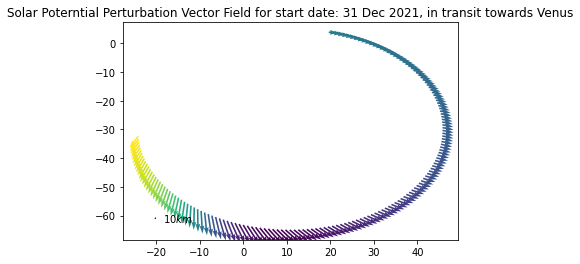

In [205]:
fig31, ax31 = plt.subplots()
#plt.figure(figsize=(20,20)) 
ax31.set_title('Solar Poterntial Perturbation Vector Field for start date: 31 Dec 2021, in transit towards Venus')
#Q = ax1.quiver(X, Y, Wx, Wy, Wz, units='width', pivot="tail")  #were X and Y represent the base of location of an arrow on XY-plane (2D) and Wx, Wy and Wz are the cartesian
                                                                #coordinates that direct where the quiver(arrow) is expected to point at.
Q = ax31.quiver(X2[:,3], X2[:,4], Y2[:,3],Y2[:,4],Y2[:,5])  
 #Remember, it is a 2D plane, so only the U.VX and U.VY components are to be considered for the base,
# but for the vector itself, can use depth to validate its direction. And prefer that the arrow starts from the unperturbed curve to the
# perturbed curve. The 'Z' coordinate component is defined via color, darker colors represent negative while warmer ones represent positive.
qk = ax31.quiverkey(Q, 0.2, 0.2, 0.9, r'$10 {km}$', labelpos='E',
                   coordinates='figure')

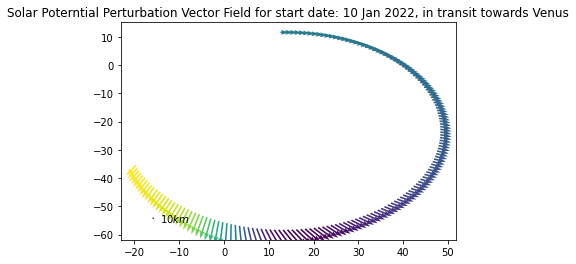

In [206]:
fig32, ax32 = plt.subplots()
#plt.figure(figsize=(20,20)) 
ax32.set_title('Solar Poterntial Perturbation Vector Field for start date: 10 Jan 2022, in transit towards Venus')
#Q = ax1.quiver(X, Y, Wx, Wy, Wz, units='width', pivot="tail", width = #)  #were X and Y represent the base of location of an arrow on XY-plane (2D) and Wx, Wy and Wz are the cartesian
                                                                #coordinates that direct where the quiver(arrow) is expected to point at.
Q = ax32.quiver(X3[:,3], X3[:,4], Y3[:,3],Y3[:,4],Y3[:,5])  
 #Remember, it is a 2D plane, so only the U.VX and U.VY components are to be considered for the base,
# but for the vector itself, can use depth to validate its direction. And prefer that the arrow starts from the unperturbed curve to the
# perturbed curve. The 'Z' coordinate component is defined via color, darker colors represent negative while warmer ones represent positive.
qk = ax32.quiverkey(Q, 0.2, 0.2, 0.9, r'$10 {km}$', labelpos='E',
                   coordinates='figure')